In [1]:
from EmuLP import Cosmology, Filter, Galaxy, Estimator, Extinction, Template

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax_cosmo as jc
import jax.numpy as jnp
from jax import vmap, jit
import json, pickle
import os,sys,copy
from tqdm import tqdm
from collections import namedtuple

from scipy.interpolate import interp1d
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline as j_spline

2023-09-29 16:49:06.518624: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
Cosmo = namedtuple('Cosmo', ['h0', 'om0', 'l0', 'omt'])
sedpyFilter = namedtuple('sedpyFilter', ['name', 'wavelengths', 'transmission'])
BaseTemplate = namedtuple('BaseTemplate', ['name', 'flux'])
Observation = namedtuple('Observation', ['num', 'AB_fluxes', 'AB_f_errors', 'z_spec'])
DustLaw = namedtuple('DustLaw', ['name', 'EBV', 'transmission'])

In [3]:
conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-togglePriorTrue-opa.json' # attention à la localisation du fichier !
with open(conf_json, "r") as inpfile:
    inputs = json.load(inpfile)

#cosmo = Cosmology.make_jcosmo(inputs['Cosmology']['h0'])
cosmo = Cosmo(inputs['Cosmology']['h0'], inputs['Cosmology']['om0'], inputs['Cosmology']['l0'],\
              inputs['Cosmology']['om0']+inputs['Cosmology']['l0'])

z_grid = jnp.arange(inputs['Z_GRID']['z_min'],\
                    inputs['Z_GRID']['z_max']+inputs['Z_GRID']['z_step'],\
                    inputs['Z_GRID']['z_step'])

fine_z_grid = jnp.arange(inputs['Z_GRID']['z_min'],\
                         inputs['Z_GRID']['z_max']+min(0.01,inputs['Z_GRID']['z_step']),\
                         min(0.01,inputs['Z_GRID']['z_step']))

wl_grid = jnp.arange(inputs['WL_GRID']['lambda_min'],\
                     inputs['WL_GRID']['lambda_max']+inputs['WL_GRID']['lambda_step'],\
                     inputs['WL_GRID']['lambda_step'])

print("Loading filters :")
filters_dict = inputs['Filters']
filters_arr = tuple( sedpyFilter(*Filter.load_filt(filters_dict[ident]["name"],\
                                                   filters_dict[ident]["path"],\
                                                   filters_dict[ident]["transmission"]\
                                                  )\
                                )
                    for ident in tqdm(filters_dict) )
N_FILT = len(filters_arr)



filters_jarr = tuple( Filter.sedpyFilter(*Filter.load_filt(int(ident),\
                                                           filters_dict[ident]["path"],\
                                                           filters_dict[ident]["transmission"]\
                                                          )\
                                        )
                     for ident in filters_dict )

print("Building templates :")
templates_dict = inputs['Templates']
baseTemp_arr = tuple( BaseTemplate(*Template.make_base_template(templates_dict[ident]["name"],\
                                                                templates_dict[ident]["path"],\
                                                                wl_grid
                                                               )\
                                  )
                     for ident in tqdm(templates_dict) )

#baseFluxes_arr = jnp.row_stack((bt.flux for bt in baseTemp_arr))

print("Generating dust attenuations laws :")
extlaws_dict = inputs['Extinctions']
dust_arr = []
for ident in tqdm(extlaws_dict):
    dust_arr.extend([ DustLaw(extlaws_dict[ident]['name'],\
                                 ebv,\
                                 Extinction.load_extinc(extlaws_dict[ident]['path'],\
                                                        ebv,\
                                                        wl_grid)\
                                )\
                        for ebv in tqdm(inputs['e_BV'])\
                       ])

#extlaws_arr = jnp.row_stack( (dustlaw.transmission for dustlaw in dust_arr) )

print("Loading IGM attenuations :")
opa_path = os.path.abspath(inputs['Opacity'])
_selOpa = (wl_grid < 1300.)
wls_opa = wl_grid[_selOpa]
opa_zgrid, opacity_grid = Extinction.load_opacity(opa_path, wls_opa)

print("Loading observations :")
data_path = os.path.abspath(inputs['Dataset']['path'])
data_ismag = (inputs['Dataset']['type'].lower() == 'm')

data_file_arr = np.loadtxt(data_path)
_obs_arr = []

for i in tqdm(range(data_file_arr.shape[0])):
    try:
        assert (len(data_file_arr[i,:]) == 1+2*N_FILT) or (len(data_file_arr[i,:]) == 1+2*N_FILT+1), f"At least one filter is missing in datapoint {data_file_arr[i,0]} : length is {len(data_file_arr[i,:])}, {1+2*N_FILT} values expected.\nDatapoint removed from dataset."
        #print(int(data_file_arr[i, 0]))
        if (len(data_file_arr[i,:]) == 1+2*N_FILT+1):
            observ = Observation(int(data_file_arr[i, 0]),\
                                 *Galaxy.load_galaxy(data_file_arr[i, 1:2*N_FILT+1],\
                                                     data_ismag),\
                                 data_file_arr[i, 2*N_FILT+1]\
                                )
        else:
            observ = Observation(int(data_file_arr[i, 0]),\
                                 *Galaxy.load_galaxy(data_file_arr[i, 1:2*N_FILT+1],\
                                                     data_ismag),\
                                 None\
                                )
        #print(observ.num)
        _obs_arr.extend([observ])
    except AssertionError:
        pass

Loading filters :


100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


Building templates :


100%|██████████| 29/29 [00:08<00:00,  3.46it/s]


Generating dust attenuations laws :


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1634.91it/s]


In [4]:
df_res = pd.read_pickle(f"{inputs['run name']}_results.pkl")

In [5]:
df_res

,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2
362,0.61,0.6636,CWW_Im-id546,Prevot,0.25,22.885651
8353,0.27,0.2819,CWW_Scd-id354,Calzetti,0.15,124.288612
7547,0.21,0.2215,CWW_Im-id537,Prevot,0.20,73.361610
10402,0.65,0.6595,CWW_Im-id113,Prevot,0.20,16.253048
12425,1.35,1.0201,CWW_Scd-id532,Prevot,0.20,25.719025
...,...,...,...,...,...,...
5756,2.45,2.6639,CWW_Im-id699,Calzetti,0.30,27.289156
16455,0.73,0.7336,CWW_E-id235,Calzetti,0.10,6.527909
13692,0.63,0.9258,CWW_Scd-id268,Prevot,0.05,24.314442
3751,0.87,0.8700,CWW_Im-id113,Prevot,0.15,30.635420


In [6]:
for obs in tqdm(_obs_arr):
    for i,filt in enumerate(filters_arr):
        if obs.num in df_res.index:
            df_res.loc[obs.num, f"MagAB({filt.name})"] = -2.5*jnp.log10(obs.AB_fluxes[i])-48.6
            df_res.loc[obs.num, f"err_MagAB({filt.name})"] = 1.086*obs.AB_f_errors[i]/obs.AB_fluxes[i]

100%|██████████| 1000/1000 [00:19<00:00, 50.30it/s]


In [7]:
df_res['bias'] = df_res['Photometric redshift']-df_res['True redshift']
df_res['std'] = df_res['bias']/(1.+df_res['True redshift'])
df_res['Outlier'] = np.abs(df_res['std'])>0.15
outl_rate = 100.0*len(df_res[df_res['Outlier']])/len(df_res)
print(f'Outlier rate = {outl_rate}%')

Outlier rate = 12.744090441932169%


In [8]:
df_res['G-R'] = df_res['MagAB(hsc_gHSC)']-df_res['MagAB(hsc_rHSC)']
df_res['I-Z'] = df_res['MagAB(hsc_iHSC)']-df_res['MagAB(hsc_zHSC)']
df_res['redness'] = df_res['G-R']/df_res['I-Z']
df_res

,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,MagAB(cosmos_u_cfht),err_MagAB(cosmos_u_cfht),MagAB(cosmos_u_new),err_MagAB(cosmos_u_new),...,MagAB(hsc_zHSC),err_MagAB(hsc_zHSC),MagAB(hsc_yHSC),err_MagAB(hsc_yHSC),bias,std,Outlier,G-R,I-Z,redness
362,0.61,0.6636,CWW_Im-id546,Prevot,0.25,22.885651,23.055801,0.006687,23.135086,0.006440,...,21.681114,0.006234,21.581612,0.007518,-5.360005e-02,-3.221931e-02,False,0.526108,0.043381,12.127682
8353,0.27,0.2819,CWW_Scd-id354,Calzetti,0.15,124.288612,21.736763,0.002886,21.713112,0.003039,...,19.379829,0.002413,19.226929,0.002557,-1.190002e-02,-9.283110e-03,False,0.841972,0.213699,3.939986
7547,0.21,0.2215,CWW_Im-id537,Prevot,0.20,73.361610,21.817879,0.001950,21.818497,0.002975,...,20.397652,0.003857,20.312340,0.004316,-1.150001e-02,-9.414659e-03,False,0.437439,0.051315,8.524532
10402,0.65,0.6595,CWW_Im-id113,Prevot,0.20,16.253048,23.978828,0.012547,24.000778,0.024770,...,21.858215,0.008252,21.678215,0.009633,-9.500024e-03,-5.724630e-03,False,0.734962,0.208145,3.531009
12425,1.35,1.0201,CWW_Scd-id532,Prevot,0.20,25.719025,24.346573,0.015538,24.361618,0.025074,...,22.694069,0.011409,22.185799,0.011367,3.298999e-01,1.633087e-01,True,0.417557,0.333847,1.250743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,2.45,2.6639,CWW_Im-id699,Calzetti,0.30,27.289156,24.917824,0.019804,25.060646,0.036556,...,23.791687,0.019078,23.761284,0.029802,-2.139000e-01,-5.838040e-02,False,0.265167,0.040230,6.591314
16455,0.73,0.7336,CWW_E-id235,Calzetti,0.10,6.527909,25.367477,0.083488,25.534828,0.119682,...,20.173088,0.003468,19.879967,0.003540,-3.600041e-03,-2.076627e-03,False,1.718857,0.430695,3.990895
13692,0.63,0.9258,CWW_Scd-id268,Prevot,0.05,24.314442,23.373314,0.007033,23.309196,0.010245,...,21.311661,0.005163,21.131180,0.005704,-2.958000e-01,-1.535985e-01,True,0.572289,0.318642,1.796025
3751,0.87,0.8700,CWW_Im-id113,Prevot,0.15,30.635420,23.422783,0.006462,23.356186,0.011524,...,21.451469,0.005597,21.319901,0.006395,-5.483627e-08,-2.932421e-08,False,0.490936,0.300888,1.631624


<AxesSubplot:xlabel='G-R', ylabel='I-Z'>

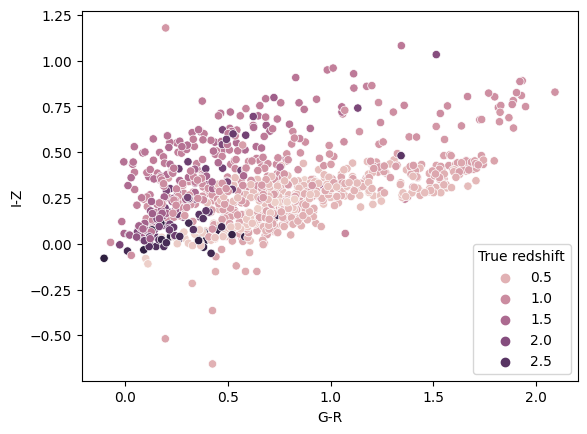

In [9]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='G-R', y='I-Z', hue='True redshift', ax=a)

<AxesSubplot:xlabel='G-R', ylabel='I-Z'>

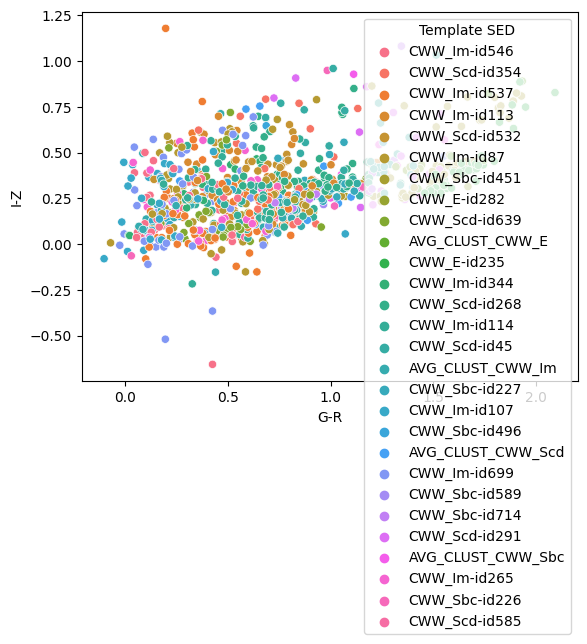

In [10]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='G-R', y='I-Z', hue='Template SED', ax=a)

Text(0.5, 1.0, 'EmuLP on COSMOS2020 subset, prior=True, Outliers rate=12.744%')

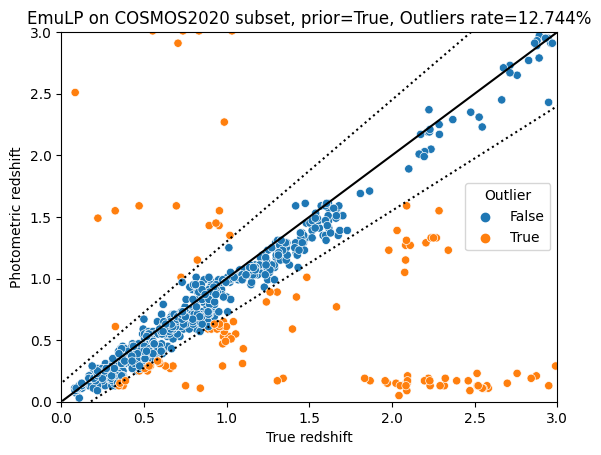

In [11]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='True redshift', y='Photometric redshift', hue='Outlier', ax=a)
a.plot(z_grid, z_grid, c='k')
a.plot(z_grid, z_grid+0.15*(1+z_grid), c='k', ls=':')
a.plot(z_grid, z_grid-0.15*(1+z_grid), c='k', ls=':')
a.set_xlim(0.,3.0)
a.set_ylim(0.,3.0)
a.set_title(f"EmuLP on COSMOS2020 subset, prior={inputs['prior']}, Outliers rate={outl_rate:.3f}%")

In [12]:
with open(f"{inputs['run name']}_results_dicts.pkl", 'rb') as handle:
    results_dict=pickle.load(handle)

In [13]:
keys = [key for key in results_dict.keys()]
test_num = 0
_ex_=keys[test_num]
zps=z_grid

In [14]:
key_0=_ex_
_dict_0=results_dict[key_0]
_dict_0.shape

(29, 20, 101)

## Integral of the probability distribution

We compute $P(z,mod,law,ebv)=\exp(-\frac{\chi^2}{2})$

In [15]:
probs_0 = jnp.exp(-0.5*_dict_0)

We average over models

In [16]:
int_over_mods = jnp.trapz(probs_0, x=jnp.arange(len(baseTemp_arr)), axis=0) #jnp.sum(probs_0, axis=0) / len(baseTemp_arr)
int_over_mods.shape

(20, 101)

We split the array according to the choice of extinction law, then we sum each sub_array to compute the integral over laws :

In [17]:
sub_ints = jnp.split(int_over_mods, len(inputs['Extinctions']), axis=0)
for sub_arr in sub_ints :
    print(sub_arr.shape)
int_over_laws = jnp.zeros_like(sub_ints[0])
for sub_arr in sub_ints:
    int_over_laws += sub_arr
int_over_laws /= len(sub_ints)
int_over_laws.shape

(10, 101)
(10, 101)


(10, 101)

We integrate on E(B-V) over axis 0

In [18]:
int_over_ebv = jnp.trapz(int_over_laws, x=jnp.array(inputs['e_BV']), axis=0)
int_over_ebv.shape

(101,)

Finally we integrate over redshift:

In [19]:
int_over_z = jnp.trapz(int_over_ebv, x=z_grid, axis=0)
int_over_z

DeviceArray(1.2778529e-08, dtype=float32)

### Test : we normalise the distribution by this value and recompute the integral. The final result should be 1.

In [20]:
# Normalization
probs_0_norm = probs_0 / int_over_z

# Integration over mods
_int_mods = jnp.trapz(probs_0_norm, x=jnp.arange(len(baseTemp_arr)), axis=0) #jnp.sum(probs_0, axis=0) / len(baseTemp_arr)

# Integration over laws
_sub_ints = jnp.split(_int_mods, len(inputs['Extinctions']), axis=0)
_int_laws = jnp.zeros_like(_sub_ints[0])
for sub_arr in _sub_ints:
    _int_laws += sub_arr
_int_laws /= len(sub_ints)

# Integration over E(B-V)
_int_ebv = jnp.trapz(_int_laws, x=jnp.array(inputs['e_BV']), axis=0)

# Final integration, over redshift grid
_int_z = jnp.trapz(_int_ebv, x=z_grid, axis=0)

_int_z

DeviceArray(0.9999999, dtype=float32)

#### SCORE !!!!

#### Subtest : we integrate in a different order using trapz where possible

In [21]:
# Final integration, over redshift grid
_int_z = jnp.trapz(probs_0_norm, x=z_grid, axis=2)
print(_int_z.shape)

# Integration over mods
_int_mods = jnp.trapz(_int_z, x=jnp.arange(len(baseTemp_arr)), axis=0)
_int_mods.shape

(29, 20)


(20,)

In [22]:
# Integration over laws
_sub_ints = jnp.split(_int_mods, len(inputs['Extinctions']), axis=0)

sub_ints_ebv = []
for sub_arr in _sub_ints:
    # Integration over E(B-V)
    print(sub_arr.shape)
    _int_ebv = jnp.trapz(sub_arr, x=jnp.array(inputs['e_BV']), axis=0)
    sub_ints_ebv.append(_int_ebv)
print(sub_ints_ebv)
_int_laws = jnp.trapz(jnp.array(sub_ints_ebv), x=jnp.arange(len(sub_ints_ebv)), axis=0)
_int_laws

(10,)
(10,)
[DeviceArray(1.08207594e-07, dtype=float32), DeviceArray(1.9999998, dtype=float32)]


DeviceArray(0.99999994, dtype=float32)

#### We find the same value. This should be the preferred method as it does not involve :
- knowledge of the number of extinction laws
- non-trapz manipulation, so we are sure that we compute an integral and not mess up with any manual integration step.

In [23]:
# Again, similar to first order but with trapz :

## Over models
_int_mods = jnp.trapz(probs_0_norm, x=jnp.arange(len(baseTemp_arr)), axis=0)

_sub_ints = jnp.split(_int_mods, len(inputs['Extinctions']), axis=0)
sub_ints_ebv_z = []
for sub_arr in _sub_ints:
    ## Integration over E(B-V)
    _int_ebv = jnp.trapz(sub_arr, x=jnp.array(inputs['e_BV']), axis=0)
    
    ## Over z
    _int_z = jnp.trapz(_int_ebv, x=z_grid, axis=0)
    
    sub_ints_ebv_z.append(_int_z)

## Over laws
_int_laws = jnp.trapz(jnp.array(sub_ints_ebv_z), x=jnp.arange(len(sub_ints_ebv_z)), axis=0)

_int_laws

DeviceArray(0.99999994, dtype=float32)

In [24]:
def probability_distrib(chi2_array):
    # Compute the probability values
    probs_array = jnp.exp(-0.5*chi2_array)
    
    # Integrate successively:
    ## Over models
    _int_mods = jnp.trapz(probs_array, x=jnp.arange(1, 1+len(baseTemp_arr)), axis=0)

    _sub_ints = jnp.split(_int_mods, len(inputs['Extinctions']), axis=0)
    sub_ints_ebv_z = []
    for sub_arr in _sub_ints:
        ## Integration over E(B-V)
        _int_ebv = jnp.trapz(sub_arr, x=jnp.array(inputs['e_BV']), axis=0)

        ## Over z
        _int_z = jnp.trapz(_int_ebv, x=z_grid, axis=0)

        sub_ints_ebv_z.append(_int_z)

    ## Over laws
    _int_laws = jnp.trapz(jnp.array(sub_ints_ebv_z), x=jnp.arange(1, 1+len(sub_ints_ebv_z)), axis=0)
    
    return probs_array / _int_laws, _int_laws

In [25]:
def prob_mod(probs_array):
    # Integrate successively:
    _sub_ints = jnp.split(probs_array, len(inputs['Extinctions']), axis=1)
    sub_ints_ebv_z = []
    for sub_arr in _sub_ints:
        ## Integration over E(B-V)
        _int_ebv = jnp.trapz(sub_arr, x=jnp.array(inputs['e_BV']), axis=1)
        ## Over z
        _int_z = jnp.trapz(_int_ebv, x=z_grid, axis=1)
        sub_ints_ebv_z.append(_int_z)

    ## Over laws
    sub_ints_ebv_z_arr = jnp.array(sub_ints_ebv_z)
    _int_laws = jnp.trapz(sub_ints_ebv_z_arr, x=jnp.arange(1, 1+len(sub_ints_ebv_z)), axis=0)
    return _int_laws

def prob_ebv(probs_array):
    # Integrate successively:
    ## Over models
    _int_mods = jnp.trapz(probs_array, x=jnp.arange(1, 1+len(baseTemp_arr)), axis=0)
    
    _sub_ints = jnp.split(_int_mods, len(inputs['Extinctions']), axis=0)
    sub_ints_z = []
    for sub_arr in _sub_ints:
        ## Over z
        _int_z = jnp.trapz(sub_arr, x=z_grid, axis=1)
        sub_ints_z.append(_int_z)

    ## Over laws
    sub_ints_z_arr = jnp.array(sub_ints_z)
    _int_laws = jnp.trapz(sub_ints_z_arr, x=jnp.arange(1, 1+len(sub_ints_z)), axis=0)
    return _int_laws

def prob_z(probs_array):
    # Integrate successively:
    ## Over models
    _int_mods = jnp.trapz(probs_array, x=jnp.arange(1, 1+len(baseTemp_arr)), axis=0)
    
    _sub_ints = jnp.split(_int_mods, len(inputs['Extinctions']), axis=0)
    sub_ints_ebv = []
    for sub_arr in _sub_ints:
        ## Integration over E(B-V)
        _int_ebv = jnp.trapz(sub_arr, x=jnp.array(inputs['e_BV']), axis=0)
        sub_ints_ebv.append(_int_ebv)

    ## Over laws
    sub_ints_ebv_arr = jnp.array(sub_ints_ebv)
    _int_laws = jnp.trapz(sub_ints_ebv_arr, x=jnp.arange(1, 1+len(sub_ints_ebv)), axis=0)
    return _int_laws

def prob_law(probs_array):
    # Integrate successively:
    ## Over models
    _int_mods = jnp.trapz(probs_array, x=jnp.arange(1, 1+len(baseTemp_arr)), axis=0)
    
    _sub_ints = jnp.split(_int_mods, len(inputs['Extinctions']), axis=0)
    sub_ints_ebv_z = []
    for sub_arr in _sub_ints:
        ## Integration over E(B-V)
        _int_ebv = jnp.trapz(sub_arr, x=jnp.array(inputs['e_BV']), axis=0)               
        ## Over z
        _int_z = jnp.trapz(_int_ebv, x=z_grid, axis=0)
        sub_ints_ebv_z.append(_int_z)
    sub_ints_z_arr = jnp.array(sub_ints_ebv_z)
    return sub_ints_z_arr

def evidence(probs_array, split_laws=False):
    # it is really just returning the array integrated over z
    if split_laws:
        # returned dimension will be nb of laws, nb of base templates, nb of E(B-V)
        _sub_ints = jnp.split(probs_array, len(inputs['Extinctions']), axis=1)
        sub_ints_z = []
        for sub_arr in _sub_ints:
            ## Over z
            _int_z = jnp.trapz(sub_arr, x=z_grid, axis=2)
            sub_ints_z.append(_int_z)
            res = jnp.array(sub_ints_z)
    else:
        # returned dimension will be nb of base templates, nb of laws * nb of E(B-V)
        res = jnp.trapz(probs_array, x=z_grid, axis=2)
    return res

def probs_at_fixed_z(probs_array, fixed_z, renormalize=True, prenormalize=False):
    # probs_array(n temp, n laws * n dust, len(z_grid)) -> probs_array(n temp, n laws * n dust)
    interpolated_array = jnp.zeros((probs_array.shape[0], probs_array.shape[1]))
    
    # Interpolate pdf at fixed_z
    for i in range(probs_array.shape[0]):
        for j in range(probs_array.shape[1]):
            _probs = probs_array[i,j,:]
            if prenormalize:
                _prenorm = jnp.trapz(_probs, x=z_grid, axis=0)
                _probs = _probs / _prenorm
            #f_interp = j_spline(z_grid, _probs, k=2)
            #_interp_pdf = f_interp(fixed_z)
            _interp_pdf = jnp.interp(fixed_z, z_grid, _probs)
            interpolated_array = interpolated_array.at[i,j].set(_interp_pdf)
    
    norm = 1.0
    if renormalize:
        # Integrate successively:
        ## Over models
        _int_mods = jnp.trapz(interpolated_array, x=jnp.arange(1, 1+len(baseTemp_arr)), axis=0)

        _sub_ints = jnp.split(_int_mods, len(inputs['Extinctions']), axis=0)
        sub_ints_ebv = []
        for sub_arr in _sub_ints:
            ## Integration over E(B-V)
            _int_ebv = jnp.trapz(sub_arr, x=jnp.array(inputs['e_BV']), axis=0)
            sub_ints_ebv.append(_int_ebv)
        ## Over laws
        norm = jnp.trapz(jnp.array(sub_ints_ebv), x=jnp.arange(1, 1+len(sub_ints_ebv)), axis=0)
    
    # return values array the same size as the number of based templates
    return interpolated_array / norm, norm

def p_template_at_fixed_z(probs_array, fixed_z):
    # probs_array(n temp, n laws * n dust, len(z_grid)) -> probs_array(n temp, n laws * n dust)
    interpolated_array, _norm = probs_at_fixed_z(probs_array, fixed_z, renormalize=True)
    
    # Split over dust extinction laws
    _sub_ints = jnp.split(interpolated_array, len(inputs['Extinctions']), axis=1)
    sub_ints_ebv = []
    for sub_arr in _sub_ints:
        ## Marginalize over E(B-V)
        _int_ebv = jnp.trapz(sub_arr, x=jnp.array(inputs['e_BV']), axis=1)
        sub_ints_ebv.append(_int_ebv)

    # Marginalize over extinction law
    sub_ints_ebv_arr = jnp.array(sub_ints_ebv)
    int_laws = jnp.trapz(sub_ints_ebv_arr, x=jnp.arange(1, 1+len(sub_ints_ebv)), axis=0)

    # return values array the same size as the number of based templates
    return int_laws

In [26]:
probs_0, norm_0 = probability_distrib(_dict_0)
print(norm_0)

1.2778529e-08


In [27]:
chi_corr = _dict_0 + 2*jnp.log(norm_0)

In [28]:
probs_1, norm_1 = probability_distrib(chi_corr)
print(norm_1)

0.9999995


In [29]:
chi_corr_1 = chi_corr + 2*jnp.log(norm_1)
probs_2, norm_2 = probability_distrib(chi_corr_1)
print(norm_2)

1.0


1.0000000809778387

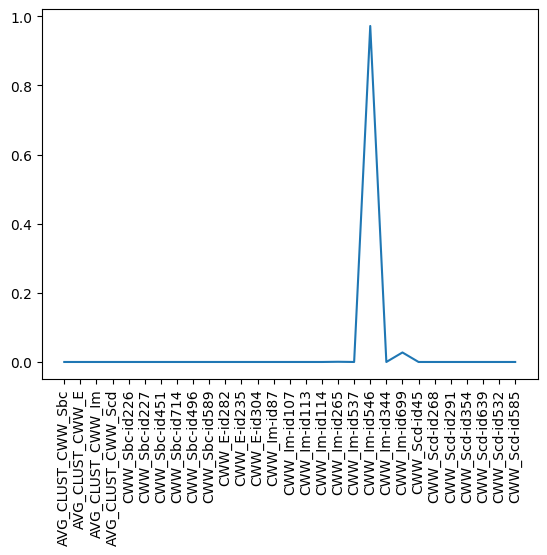

In [30]:
f,a=plt.subplots(1,1)
a.plot(np.array([t.name for t in baseTemp_arr]), prob_mod(probs_2))
a.tick_params(axis='x', labelrotation=90)
np.trapz(prob_mod(probs_2), np.arange(len(baseTemp_arr)))

1.0


1.0

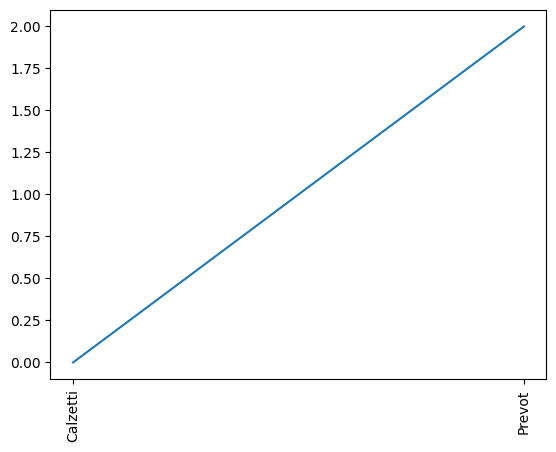

In [31]:
f,a=plt.subplots(1,1)
a.plot(np.unique([d.name for d in dust_arr]), prob_law(probs_2))
a.tick_params(axis='x', labelrotation=90)
print(np.sum(prob_law(probs_2))/len(inputs['Extinctions']))
np.trapz(prob_law(probs_2), np.arange(1, 1+len(inputs['Extinctions'])))

0.9999998927860898

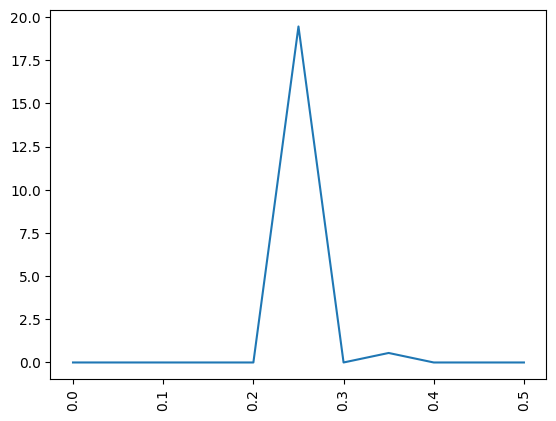

In [32]:
f,a=plt.subplots(1,1)
a.plot(np.array(inputs['e_BV']), prob_ebv(probs_2))
a.tick_params(axis='x', labelrotation=90)
np.trapz(prob_ebv(probs_2), np.array(inputs['e_BV']))

1.0

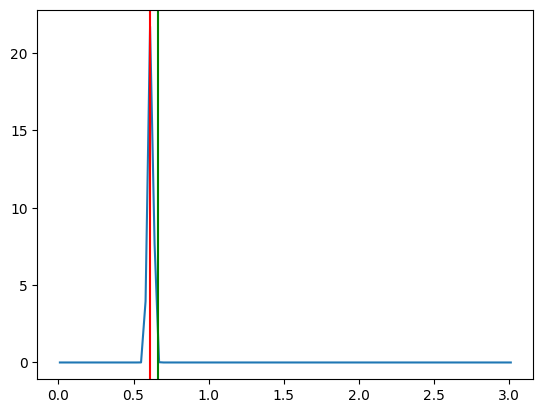

In [33]:
f,a=plt.subplots(1,1)
a.plot(z_grid, prob_z(probs_2))
a.axvline(df_res.loc[key_0, 'True redshift'], c='green', label="$z_{spectro}$")
a.axvline(df_res.loc[key_0, 'Photometric redshift'], c='red', label="$z_{photo}$")
np.trapz(prob_z(probs_2), z_grid)

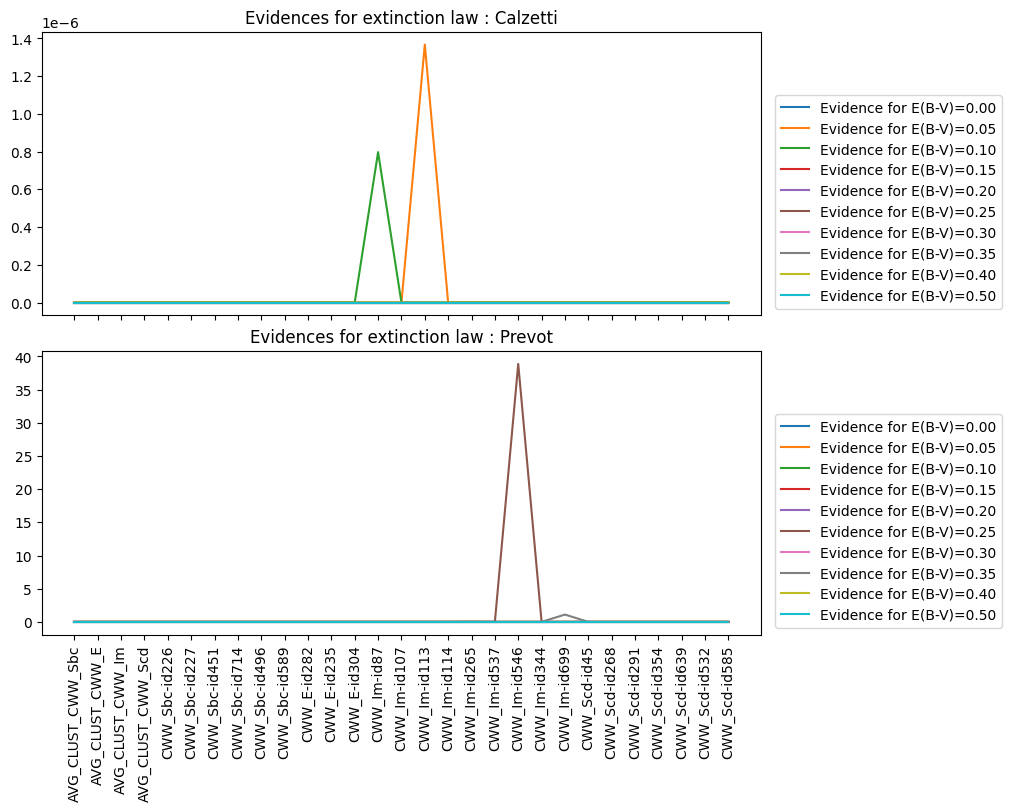

In [34]:
evs = evidence(probs_2, split_laws=True)
temp_names_arr = np.array([t.name for t in baseTemp_arr])
f,a=plt.subplots(2,1, figsize=(10, 8), sharex=True, constrained_layout=True)
a=a.ravel()
for law_ind, law_name in enumerate(inputs['Extinctions']):
    for ebv_ind, ebv in enumerate(inputs['e_BV']):
        a[law_ind].plot(temp_names_arr, evs[law_ind,:,ebv_ind], label=f'Evidence for E(B-V)={ebv:.2f}')
    a[law_ind].legend(loc='lower left', bbox_to_anchor=(1.01,0.0))
    a[law_ind].tick_params(axis='x', labelrotation=90)
    a[law_ind].set_title(f"Evidences for extinction law : {extlaws_dict[law_name]['name']}")

Text(0.5, 0, 'E(B-V)')

/opt/conda/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


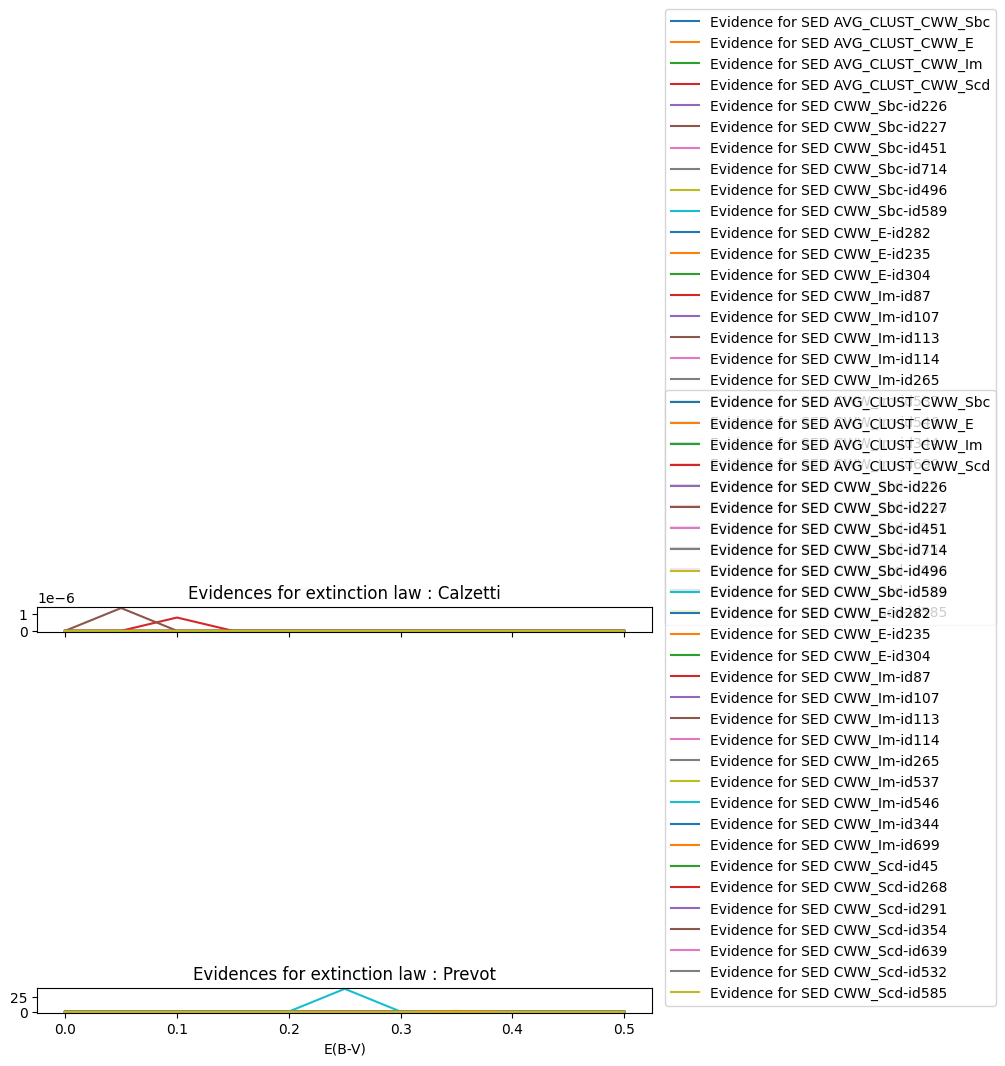

In [35]:
evs = evidence(probs_2, split_laws=True)
temp_names_arr = np.array([t.name for t in baseTemp_arr])
f,a=plt.subplots(2,1, figsize=(10, 8), sharex=True, constrained_layout=True)
a=a.ravel()
for law_ind, law_name in enumerate(inputs['Extinctions']):
    for temp_ind, temp_name in enumerate(temp_names_arr):
        a[law_ind].plot(inputs['e_BV'], evs[law_ind,temp_ind,:], label=f'Evidence for SED {temp_name}')
    a[law_ind].legend(loc='lower left', bbox_to_anchor=(1.01,0.0))
    a[law_ind].set_title(f"Evidences for extinction law : {extlaws_dict[law_name]['name']}")

a[-1].set_xlabel('E(B-V)')

In [36]:
evs_nosplit = evidence(probs_2, split_laws=False)
sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
print(sorted_evs_flat.shape)
sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
sorted_evs.reverse()
sorted_evs[:10]

(580,)


[(DeviceArray(19, dtype=int32), DeviceArray(15, dtype=int32)),
 (DeviceArray(21, dtype=int32), DeviceArray(17, dtype=int32)),
 (DeviceArray(17, dtype=int32), DeviceArray(15, dtype=int32)),
 (DeviceArray(15, dtype=int32), DeviceArray(11, dtype=int32)),
 (DeviceArray(14, dtype=int32), DeviceArray(15, dtype=int32)),
 (DeviceArray(18, dtype=int32), DeviceArray(13, dtype=int32)),
 (DeviceArray(15, dtype=int32), DeviceArray(1, dtype=int32)),
 (DeviceArray(14, dtype=int32), DeviceArray(16, dtype=int32)),
 (DeviceArray(13, dtype=int32), DeviceArray(2, dtype=int32)),
 (DeviceArray(13, dtype=int32), DeviceArray(12, dtype=int32))]

Text(0, 0.5, '$P(z|model)$')

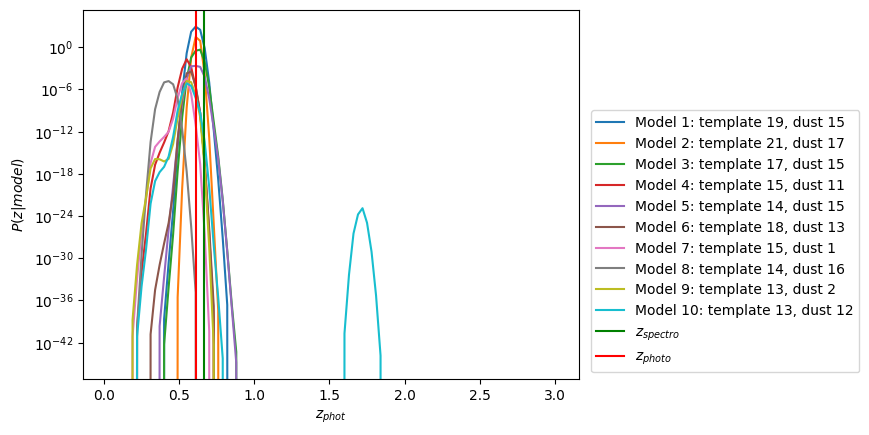

In [37]:
f,a = plt.subplots(1,1)
NMOD=10
for nmod, (n_temp, n_dust) in enumerate(sorted_evs[:NMOD]):
    a.semilogy(z_grid, probs_2[n_temp, n_dust, :],\
               label = f'Model {1+nmod}: template {n_temp}, dust {n_dust}')

a.axvline(df_res.loc[key_0, 'True redshift'], c='green', label="$z_{spectro}$")
a.axvline(df_res.loc[key_0, 'Photometric redshift'], c='red', label="$z_{photo}$")
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))
a.set_xlabel('$z_{phot}$')
a.set_ylabel("$P(z|model)$")

Tiens tiens ! Sur la base du calcul de l'evidence du modèle ($\int PDF(z|model)dz$), un autre modèle, avec par exemple un prior sur la valeur E(B-V), aurait peut-être permis de retrouver $z_{spectro}$.

(0.5, 1.0)

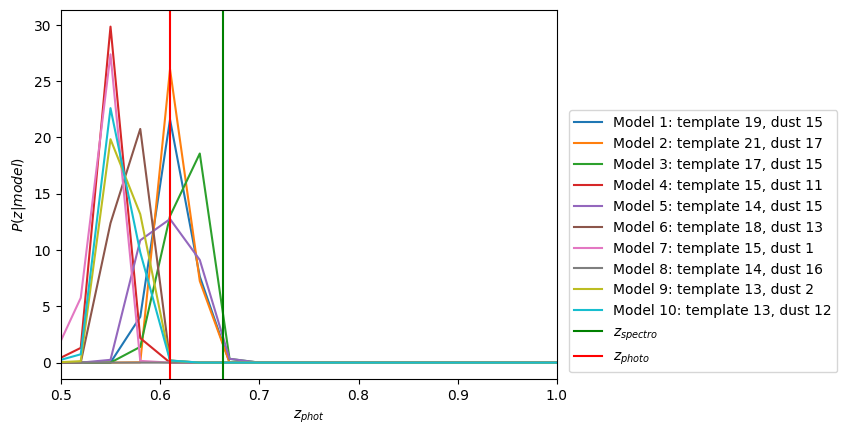

In [38]:
f,a = plt.subplots(1,1)
NMOD=10
for nmod, (n_temp, n_dust) in enumerate(sorted_evs[:NMOD]):
    a.plot(z_grid, probs_2[n_temp, n_dust, :]/jnp.trapz(probs_2[n_temp, n_dust, :], x=z_grid),\
           label = f'Model {1+nmod}: template {n_temp}, dust {n_dust}')

a.axvline(df_res.loc[key_0, 'True redshift'], c='green', label="$z_{spectro}$")
a.axvline(df_res.loc[key_0, 'Photometric redshift'], c='red', label="$z_{photo}$")
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))
a.set_xlabel('$z_{phot}$')
a.set_ylabel("$P(z|model)$")
a.set_xlim(0.5,1.)

In [39]:
model_df_0=pd.DataFrame()
extrap_ones = jnp.ones(len(wl_grid)-len(wls_opa))

for nmod, (n_temp, n_dust) in enumerate(tqdm(sorted_evs[:NMOD])):
    model_df_0.loc[nmod, "Template SED"] = baseTemp_arr[n_temp].name
    model_df_0.loc[nmod, "Dust law"] = dust_arr[n_dust].name
    model_df_0.loc[nmod, "E(B-V)"] = dust_arr[n_dust].EBV
    z_distrib = probs_2[n_temp, n_dust, :] / jnp.trapz(probs_2[n_temp, n_dust, :], x=z_grid)
    cum_distr = jnp.cumsum(z_distrib)
    model_df_0.loc[nmod, "zp (mode)"] = z_grid[jnp.nanargmax(z_distrib)]
    opa_at_z = jnp.array([jnp.interp(model_df_0.loc[nmod, "zp (mode)"], opa_zgrid, opacity_grid[:, _col]) for _col in range(opacity_grid.shape[1])])
    opacities = jnp.append(opa_at_z, extrap_ones)
    templ_fab = Template.make_scaled_template(baseTemp_arr[n_temp].flux, filters_jarr,\
                                              dust_arr[n_dust].transmission,\
                                              _obs_arr[test_num].AB_fluxes, _obs_arr[test_num].AB_f_errors,\
                                              model_df_0.loc[nmod, "zp (mode)"], wl_grid,\
                                              Cosmology.distMod(cosmo, model_df_0.loc[nmod, "zp (mode)"]),\
                                              opacities
                                             )
    templ_mab = -2.5*jnp.log10(templ_fab)-48.6
    model_df_0.loc[nmod, "Average z"] = jnp.trapz(z_distrib*z_grid, x=z_grid)
    model_df_0.loc[nmod, "Sigma z"] = jnp.trapz(z_distrib*jnp.power(z_grid-model_df_0.loc[nmod, "Average z"], 2), x=z_grid)
    _selmed = cum_distr > 0.5
    model_df_0.loc[nmod, "Median z"] = z_grid[_selmed][0]
    model_df_0.loc[nmod, [f"M({f.name})" for f in filters_arr]] = templ_mab
    model_df_0.loc[nmod, "Odd ratio"] = evs_nosplit[sorted_evs[nmod]]/evs_nosplit[sorted_evs[0]]
    model_df_0.loc[nmod, "Bias"] = jnp.abs(model_df_0.loc[nmod, "zp (mode)"] - _obs_arr[test_num].z_spec)/(1+_obs_arr[test_num].z_spec)
model_df_0

100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


,Template SED,Dust law,E(B-V),zp (mode),Average z,Sigma z,Median z,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC),Odd ratio,Bias
0,CWW_Im-id546,Prevot,0.25,0.61,0.613252,0.000308,0.58,23.056297,23.128281,22.688316,22.149353,21.757156,21.636200,21.597618,1.000000e+00,0.032219
1,CWW_Im-id699,Prevot,0.35,0.61,0.616495,0.000154,0.61,23.053490,23.142632,22.666618,22.136742,21.736336,21.636597,21.653900,2.831067e-02,0.032219
2,CWW_Im-id265,Prevot,0.25,0.64,0.626053,0.000318,0.58,23.030586,23.103424,22.686539,22.209450,21.768639,21.638199,21.583809,6.176337e-04,0.014186
3,CWW_Im-id113,Prevot,0.05,0.55,0.550782,0.000094,0.52,23.073830,23.118660,22.773491,22.132599,21.765266,21.629677,21.558929,1.661886e-05,0.068286
4,CWW_Im-id107,Prevot,0.25,0.61,0.608602,0.000602,0.58,23.026886,23.102837,22.663696,22.195549,21.793137,21.638031,21.575813,4.477552e-06,0.032219
5,CWW_Im-id537,Prevot,0.15,0.58,0.569002,0.000219,0.55,23.084999,23.123795,22.819687,22.151619,21.728188,21.619934,21.582031,4.070432e-07,0.050252
6,CWW_Im-id113,Calzetti,0.05,0.55,0.544885,0.000138,0.52,23.063309,23.098183,22.790375,22.144867,21.778816,21.633224,21.551323,3.516591e-08,0.068286
7,CWW_Im-id107,Prevot,0.30,0.43,0.424672,0.000471,0.40,23.084023,23.163147,22.720894,22.057312,21.768333,21.643845,21.579613,2.377663e-08,0.140418
8,CWW_Im-id87,Calzetti,0.10,0.55,0.562066,0.000233,0.55,23.089577,23.138847,22.783371,22.133430,21.764008,21.618790,21.530586,2.050381e-08,0.068286
9,CWW_Im-id87,Prevot,0.10,0.55,0.558492,0.000234,0.52,23.111809,23.181328,22.751236,22.110657,21.738731,21.613518,21.547661,8.162441e-09,0.068286


In [40]:
_zps = np.array([])
chi2s = np.array([])
probs = np.array([])
modids = np.array([])
extlaws = np.array([])
ebvs = np.array([])

for i,mod in enumerate(tqdm(baseTemp_arr)):
    for j, dust in enumerate(dust_arr):
        _zps = np.append(_zps, fine_z_grid)
        #f_interp = interp1d(z_grid, _dict_0[i, j, :], kind='cubic', bounds_error=False, fill_value="extrapolate")
        f_interp = j_spline(z_grid, chi_corr_1[i, j, :], k=3)
        _interp_chis = f_interp(fine_z_grid) # np.interp(fine_z_grid, z_grid, _dict_0[i, j, :])
        p_interp = j_spline(z_grid, probs_2[i, j, :], k=1)
        _interp_ps = p_interp(fine_z_grid) # np.interp(fine_z_grid, z_grid, _dict_0[i, j, :])
        chi2s = np.append(chi2s, _interp_chis)
        probs = np.append(probs, _interp_ps)
        modids = np.append(modids, np.full(fine_z_grid.shape, mod.name))
        extlaws = np.append(extlaws, np.full(fine_z_grid.shape, dust.name))
        ebvs = np.append(ebvs, np.full(fine_z_grid.shape, dust.EBV))

dict_0 = {}
dict_0['zp'] = _zps
dict_0['chi2'] = chi2s
dict_0['mod id'] = modids
dict_0['ext law'] = extlaws
dict_0['eBV'] = ebvs
dict_0['PDF'] = probs

100%|██████████| 29/29 [00:37<00:00,  1.28s/it]


In [41]:
df0 = pd.DataFrame(dict_0)
df0

,zp,chi2,mod id,ext law,eBV,PDF
0,0.01,1401.895874,AVG_CLUST_CWW_Sbc,Calzetti,0.0,0.0
1,0.02,1529.114502,AVG_CLUST_CWW_Sbc,Calzetti,0.0,0.0
2,0.03,1637.343994,AVG_CLUST_CWW_Sbc,Calzetti,0.0,0.0
3,0.04,1729.963257,AVG_CLUST_CWW_Sbc,Calzetti,0.0,0.0
4,0.05,1810.350708,AVG_CLUST_CWW_Sbc,Calzetti,0.0,0.0
...,...,...,...,...,...,...
173995,2.96,NaN,CWW_Scd-id585,Prevot,0.5,0.0
173996,2.97,NaN,CWW_Scd-id585,Prevot,0.5,0.0
173997,2.98,NaN,CWW_Scd-id585,Prevot,0.5,0.0
173998,2.99,NaN,CWW_Scd-id585,Prevot,0.5,0.0


<AxesSubplot:xlabel='zp', ylabel='PDF'>

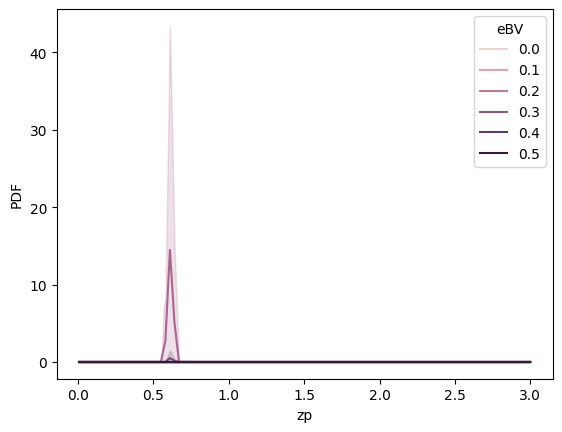

In [42]:
sns.lineplot(data=df0, x='zp', y='PDF', hue='eBV')

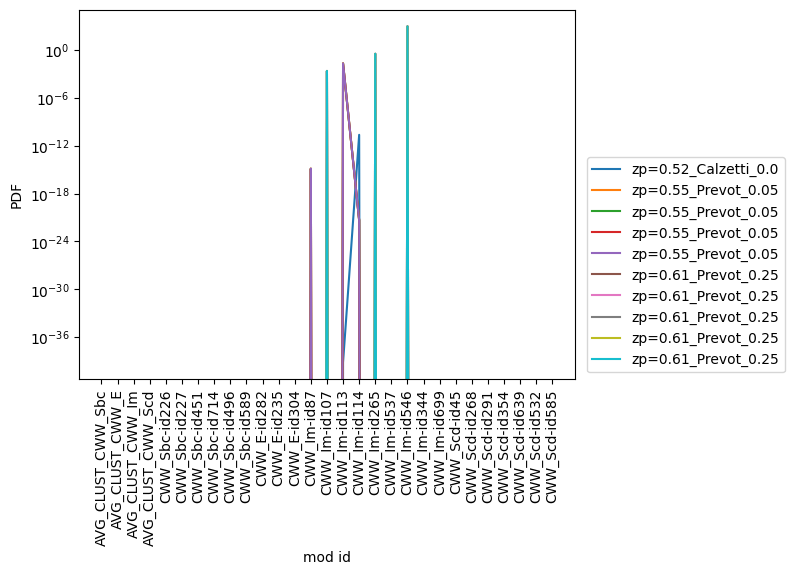

In [43]:
f,a = plt.subplots(1,1)
max_evidence = -1.
best_z = ''
best_law = ''
best_ebv = -1.0
for ebv in np.unique(df0['eBV']):
    for law_ind, law_name in enumerate(np.unique(df0['ext law'])):
        for zp_ind, z_val in enumerate(np.unique(df0['zp'])):
            _sel = (df0['zp']==z_val) * (df0['ext law']==law_name) * (df0['eBV']==ebv)
            _df = df0[_sel]
            ev_ = np.trapz(_df['PDF'].values, x=np.arange(len(_df['mod id'])))
            if ev_ > max_evidence:
                best_z = z_val
                best_law = law_name
                best_ebv = ebv
                max_evidence = ev_
    _selplot = (df0['zp']==best_z) * (df0['ext law']==best_law) * (df0['eBV']==best_ebv)
    _df_plot = df0[_selplot]
    sns.lineplot(data=_df_plot, x='mod id', y='PDF', ax=a, label=f"zp={best_z:.2f}_{best_law}_{best_ebv}")

#a.axvline(df_res.loc[key_0, 'True redshift'],\
#            label=f"True z={df_res.loc[key_0, 'True redshift']:.2f}", c='g')
#a.axvline(df_res.loc[key_0, 'Photometric redshift'],\
#            label=f"Photo-z={df_res.loc[key_0, 'Photometric redshift']:.2f}", c='purple')
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.))
a.tick_params(axis='x', labelrotation=90)
a.set_yscale('log')

OK donc c'est pas complètement sans espoir ! Il faudrait intégrer la visualisation de ces résultats dans un dash maintenant...

## Fix z at spectroscopic value and look for the best-fit model

Best model at z_spec=0.6636: CWW_Im-id546 with dust as per Prevot and E(B-V)=0.25.


(0.5, 1.0)

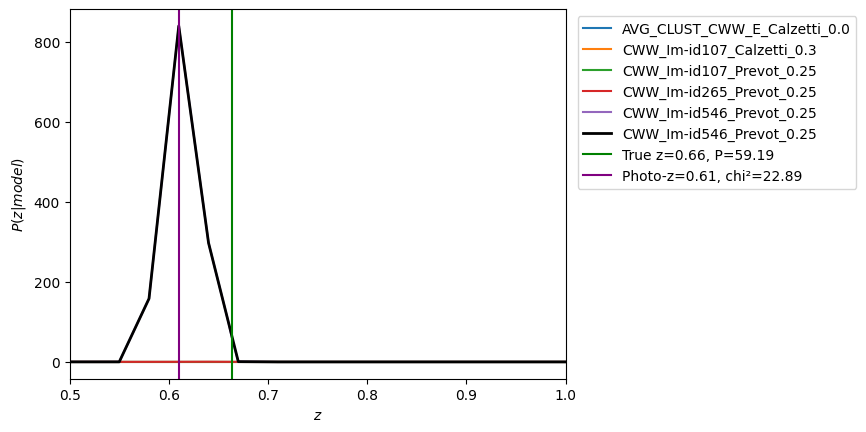

In [44]:
f,a = plt.subplots(1,1)
max_pdf = -1.0
best_temp = ''
best_law = ''
best_ebv = -1.0
best_mod_chis = np.array([])
interp_grid = np.sort(np.append(np.sort(np.unique(df0['zp'].values)), df_res.loc[key_0, 'True redshift']))
for temp_ind, temp_name in enumerate(np.unique(df0['mod id'])):
    for law_ind, law_name in enumerate(np.unique(df0['ext law'])):
        for ebv in np.unique(df0['eBV']):
            _sel = (df0['mod id']==temp_name) * (df0['ext law']==law_name) * (df0['eBV']==ebv)
            probs_sel = df0[_sel]['PDF'].values
            f_interp = j_spline(df0[_sel]['zp'].values, probs_sel, k=2)
            _interp_pdf = f_interp(df_res.loc[key_0, 'True redshift'])
            if _interp_pdf > max_pdf:
                best_temp = temp_name
                best_law = law_name
                best_ebv = ebv
                best_mod_probs = f_interp(interp_grid)
                max_pdf = _interp_pdf
                a.plot(interp_grid, best_mod_probs, label=f"{best_temp}_{best_law}_{best_ebv}")
                
photoz_temp = df_res.loc[key_0, 'Template SED']
photoz_law = df_res.loc[key_0, 'Extinction law']
photoz_ebv = df_res.loc[key_0, 'E(B-V)']
photoz_chi = df_res.loc[key_0, 'Chi2']

photoz_sel = _sel = (df0['mod id']==photoz_temp) * (df0['ext law']==photoz_law) * (df0['eBV']==photoz_ebv)
photoz_probs = jnp.array(df0[_sel]['PDF'].values)
a.plot(fine_z_grid, photoz_probs, lw=2, c='k', label=f"{photoz_temp}_{photoz_law}_{photoz_ebv}")
a.axvline(df_res.loc[key_0, 'True redshift'],\
            label=f"True z={df_res.loc[key_0, 'True redshift']:.2f}, P={max_pdf:.2f}", c='g')
a.axvline(df_res.loc[key_0, 'Photometric redshift'],\
            label=f"Photo-z={df_res.loc[key_0, 'Photometric redshift']:.2f}, chi²={photoz_chi:.2f}", c='purple')

print(f"Best model at z_spec={df_res.loc[key_0, 'True redshift']}: {best_temp} with dust as per {best_law} and E(B-V)={best_ebv}.")
a.legend(loc='upper left', bbox_to_anchor=(1.01,1.0))
a.set_xlabel('$z$')
a.set_ylabel("$P(z|model)$")
a.set_xlim(0.5, 1.0)

Le "meilleur modèle" pour $z_{spec}$ est identifié en bleu. Par contre, $z_{spec}$ n'est pas le meilleur redshift pour ce modèle ! Faut-il appliquer une correction / une calibration des filtres (un peu comme le auto-adapt) dans l'estimation?
Attendons aussi de voir avec l'opacité...
Plutôt que de chercher "le meilleur modèle" (avec le plus petit $\chi^2$) faut-il chercher celui qui atteint un minimum en $z_{spec}$? Pour l'estimation de $z_{phot}$ ça ne changera rien car la plus petite valeur de $\chi^2$ est forcément atteinte au minimum sur la grille de redshift.

In [45]:
probs_2.shape

(29, 20, 101)

In [46]:
mods_p_at_zs = p_template_at_fixed_z(probs_2, df_res.loc[key_0, 'True redshift'])
mods_p_at_zp = p_template_at_fixed_z(probs_2, df_res.loc[key_0, 'Photometric redshift'])
mods_p_at_zs.shape, mods_p_at_zp.shape

((29,), (29,))

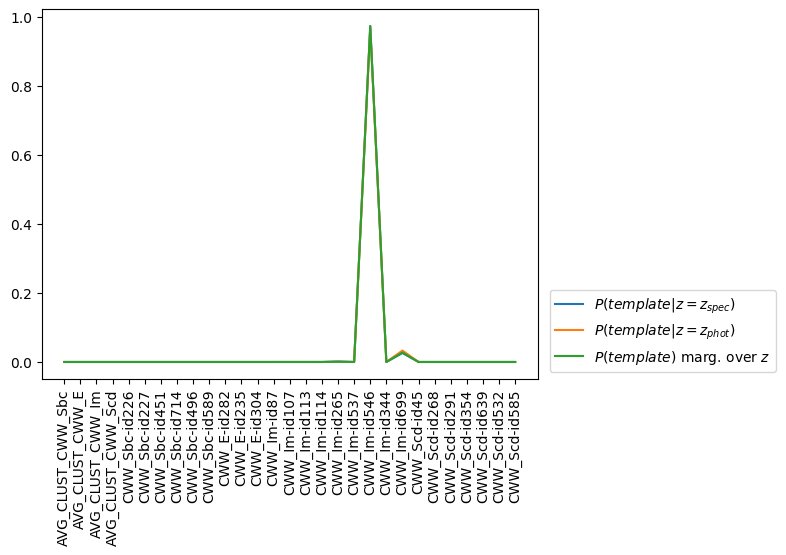

In [47]:
f,a=plt.subplots(1,1)
a.plot(np.array([t.name for t in baseTemp_arr]), mods_p_at_zs,\
       label="$P(template|z=z_{spec})$"
      )
a.plot(np.array([t.name for t in baseTemp_arr]), mods_p_at_zp,\
       label="$P(template|z=z_{phot})$"
      )
a.plot(np.array([t.name for t in baseTemp_arr]), prob_mod(probs_2),\
       label="$P(template)$ marg. over $z$"
      )
#a.set_yscale('log')
a.tick_params(axis='x', labelrotation=90)
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))

In [48]:
p_zfix_nosplit, _norm = probs_at_fixed_z(probs_2, df_res.loc[key_0, 'True redshift'], renormalize=True, prenormalize=False)
sorted_pzfix_flat = jnp.argsort(p_zfix_nosplit, axis=None)
print(sorted_pzfix_flat.shape)
sorted_pzfix = [ jnp.unravel_index(idx, p_zfix_nosplit.shape) for idx in sorted_pzfix_flat ]
sorted_pzfix.reverse()
sorted_pzfix[:10]

(580,)


[(DeviceArray(19, dtype=int32), DeviceArray(15, dtype=int32)),
 (DeviceArray(21, dtype=int32), DeviceArray(17, dtype=int32)),
 (DeviceArray(17, dtype=int32), DeviceArray(15, dtype=int32)),
 (DeviceArray(14, dtype=int32), DeviceArray(15, dtype=int32)),
 (DeviceArray(13, dtype=int32), DeviceArray(12, dtype=int32)),
 (DeviceArray(18, dtype=int32), DeviceArray(13, dtype=int32)),
 (DeviceArray(15, dtype=int32), DeviceArray(11, dtype=int32)),
 (DeviceArray(13, dtype=int32), DeviceArray(2, dtype=int32)),
 (DeviceArray(15, dtype=int32), DeviceArray(1, dtype=int32)),
 (DeviceArray(21, dtype=int32), DeviceArray(8, dtype=int32))]

Text(0, 0.5, '$P(z|model)$')

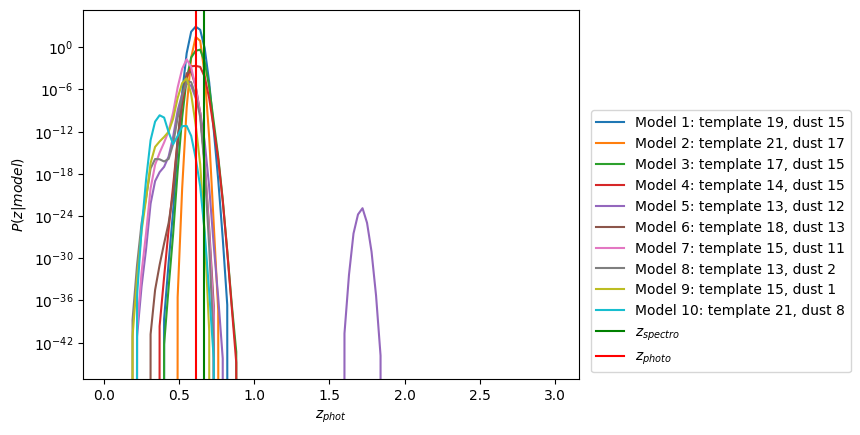

In [49]:
f,a = plt.subplots(1,1)
NMOD=10
for nmod, (n_temp, n_dust) in enumerate(sorted_pzfix[:NMOD]):
    a.semilogy(z_grid, probs_2[n_temp, n_dust, :],\
               label = f'Model {1+nmod}: template {n_temp}, dust {n_dust}')

a.axvline(df_res.loc[key_0, 'True redshift'], c='green', label="$z_{spectro}$")
a.axvline(df_res.loc[key_0, 'Photometric redshift'], c='red', label="$z_{photo}$")
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))
a.set_xlabel('$z_{phot}$')
a.set_ylabel("$P(z|model)$")

In [50]:
modelZFIX_df_0=pd.DataFrame()
extrap_ones = jnp.ones(len(wl_grid)-len(wls_opa))

for nmod, (n_temp, n_dust) in enumerate(tqdm(sorted_pzfix[:NMOD])):
    modelZFIX_df_0.loc[nmod, "Template SED"] = baseTemp_arr[n_temp].name
    modelZFIX_df_0.loc[nmod, "Dust law"] = dust_arr[n_dust].name
    modelZFIX_df_0.loc[nmod, "E(B-V)"] = dust_arr[n_dust].EBV
    z_distrib = probs_2[n_temp, n_dust, :] / jnp.trapz(probs_2[n_temp, n_dust, :], x=z_grid)
    cum_distr = jnp.cumsum(z_distrib)
    modelZFIX_df_0.loc[nmod, "zp (mode)"] = z_grid[jnp.nanargmax(z_distrib)]
    opa_at_z = jnp.array([jnp.interp(modelZFIX_df_0.loc[nmod, "zp (mode)"], opa_zgrid, opacity_grid[:, _col]) for _col in range(opacity_grid.shape[1])])
    opacities = jnp.append(opa_at_z, extrap_ones)
    templ_fab = Template.make_scaled_template(baseTemp_arr[n_temp].flux, filters_jarr,\
                                              dust_arr[n_dust].transmission,\
                                              _obs_arr[test_num].AB_fluxes, _obs_arr[test_num].AB_f_errors,\
                                              modelZFIX_df_0.loc[nmod, "zp (mode)"], wl_grid,\
                                              Cosmology.distMod(cosmo, modelZFIX_df_0.loc[nmod, "zp (mode)"]),\
                                              opacities
                                             )
    templ_mab = -2.5*jnp.log10(templ_fab)-48.6
    modelZFIX_df_0.loc[nmod, "Average z"] = jnp.trapz(z_distrib*z_grid, x=z_grid)
    modelZFIX_df_0.loc[nmod, "Sigma z"] = jnp.trapz(z_distrib*jnp.power(z_grid-modelZFIX_df_0.loc[nmod, "Average z"], 2), x=z_grid)
    _selmed = cum_distr > 0.5
    modelZFIX_df_0.loc[nmod, "Median z"] = z_grid[_selmed][0]
    modelZFIX_df_0.loc[nmod, [f"M({f.name})" for f in filters_arr]] = templ_mab
    modelZFIX_df_0.loc[nmod, "Odd ratio"] = p_zfix_nosplit[sorted_pzfix[nmod]]/p_zfix_nosplit[sorted_pzfix[0]]
    modelZFIX_df_0.loc[nmod, "Bias"] = jnp.abs(modelZFIX_df_0.loc[nmod, "zp (mode)"] - _obs_arr[test_num].z_spec)/(1+_obs_arr[test_num].z_spec)
modelZFIX_df_0

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


,Template SED,Dust law,E(B-V),zp (mode),Average z,Sigma z,Median z,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC),Odd ratio,Bias
0,CWW_Im-id546,Prevot,0.25,0.61,0.613252,0.000308,0.58,23.056297,23.128281,22.688316,22.149353,21.757156,21.636200,21.597618,1.000000e+00,0.032219
1,CWW_Im-id699,Prevot,0.35,0.61,0.616495,0.000154,0.61,23.053490,23.142632,22.666618,22.136742,21.736336,21.636597,21.653900,2.658419e-02,0.032219
2,CWW_Im-id265,Prevot,0.25,0.64,0.626053,0.000318,0.58,23.030586,23.103424,22.686539,22.209450,21.768639,21.638199,21.583809,1.584608e-03,0.014186
3,CWW_Im-id107,Prevot,0.25,0.61,0.608602,0.000602,0.58,23.026886,23.102837,22.663696,22.195549,21.793137,21.638031,21.575813,6.024532e-06,0.032219
4,CWW_Im-id87,Prevot,0.10,0.55,0.558492,0.000234,0.52,23.111809,23.181328,22.751236,22.110657,21.738731,21.613518,21.547661,1.663484e-12,0.068286
5,CWW_Im-id537,Prevot,0.15,0.58,0.569002,0.000219,0.55,23.084999,23.123795,22.819687,22.151619,21.728188,21.619934,21.582031,1.515342e-12,0.050252
6,CWW_Im-id113,Prevot,0.05,0.55,0.550782,0.000094,0.52,23.073830,23.118660,22.773491,22.132599,21.765266,21.629677,21.558929,1.293977e-12,0.068286
7,CWW_Im-id87,Calzetti,0.10,0.55,0.562066,0.000233,0.55,23.089577,23.138847,22.783371,22.133430,21.764008,21.618790,21.530586,3.991128e-13,0.068286
8,CWW_Im-id113,Calzetti,0.05,0.55,0.544885,0.000138,0.52,23.063309,23.098183,22.790375,22.144867,21.778816,21.633224,21.551323,7.665743e-20,0.068286
9,CWW_Im-id699,Calzetti,0.40,0.37,0.382516,0.001198,0.34,23.086166,23.128716,22.711754,22.028076,21.790520,21.676247,21.582253,5.533675e-23,0.176485


In [51]:
if True:
    seds_zs = []
    laws_zs = []
    ebvs_zs = []
    odds_zs = []

    for kk in tqdm(keys) :
        chi2arr = results_dict[kk]
        probsarr, norm = probability_distrib(chi2arr)
        while abs(1-norm)>1.0e-5 :
            chi2arr = chi2arr + 2*jnp.log(norm)
            probsarr, norm = probability_distrib(chi2arr)

        evs_nosplit = evidence(probsarr, split_laws=False)
        id_t = np.nonzero([t.name == df_res.loc[kk, "Template SED"] for t in baseTemp_arr])[0][0]
        id_dust = np.nonzero([(d.name == df_res.loc[kk, "Extinction law"]) and (d.EBV == df_res.loc[kk, "E(B-V)"]) for d in dust_arr])[0][0]

        p_zfix_nosplit, _n = probs_at_fixed_z(probsarr, df_res.loc[kk, 'True redshift'], renormalize=True, prenormalize=False)
        sorted_pzfix_flat = jnp.argsort(p_zfix_nosplit, axis=None)
        sorted_pzfix = [ jnp.unravel_index(idx, p_zfix_nosplit.shape) for idx in sorted_pzfix_flat ]
        sorted_pzfix.reverse()
        n_temp, n_dust = sorted_pzfix[0]

        seds_zs.append(baseTemp_arr[n_temp].name)
        laws_zs.append(dust_arr[n_dust].name)
        ebvs_zs.append(dust_arr[n_dust].EBV)
        odds_zs.append(evs_nosplit[n_temp, n_dust] / evs_nosplit[id_t, id_dust])

    df_res["Best SED at z_spec"] = seds_zs
    df_res["Best dust law at z_spec"] = laws_zs
    df_res["E(B-V) at z_spec"] = ebvs_zs
    df_res["Odd ratio"] = odds_zs
    df_res.to_pickle(f"results_synthesis_{inputs['run name']}.pkl")

100%|██████████| 973/973 [45:29<00:00,  2.80s/it]


In [52]:
df_res = pd.read_pickle(f"results_synthesis_{inputs['run name']}.pkl")
df_res['Odd ratio'] = np.array(df_res['Odd ratio'].values, dtype=float)
df_res

,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,MagAB(cosmos_u_cfht),err_MagAB(cosmos_u_cfht),MagAB(cosmos_u_new),err_MagAB(cosmos_u_new),...,bias,std,Outlier,G-R,I-Z,redness,Best SED at z_spec,Best dust law at z_spec,E(B-V) at z_spec,Odd ratio
362,0.61,0.6636,CWW_Im-id546,Prevot,0.25,22.885651,23.055801,0.006687,23.135086,0.006440,...,-0.0536,-0.032219,False,0.526108,0.043381,12.127682,CWW_Im-id546,Prevot,0.25,1.000000e+00
8353,0.28,0.2819,CWW_Scd-id354,Calzetti,0.15,132.078110,21.736763,0.002886,21.713112,0.003039,...,-0.0019,-0.001482,False,0.841972,0.213699,3.939986,CWW_Scd-id354,Calzetti,0.15,1.000000e+00
7547,0.22,0.2215,CWW_Im-id537,Prevot,0.20,74.491791,21.817879,0.001950,21.818497,0.002975,...,-0.0015,-0.001228,False,0.437439,0.051315,8.524532,CWW_Im-id537,Prevot,0.20,1.000000e+00
10402,0.64,0.6595,CWW_Im-id113,Prevot,0.20,16.361483,23.978828,0.012547,24.000778,0.024770,...,-0.0195,-0.011751,False,0.734962,0.208145,3.531009,CWW_Im-id113,Prevot,0.20,1.000000e+00
12425,1.33,1.0201,CWW_Scd-id532,Prevot,0.20,25.801825,24.346573,0.015538,24.361618,0.025074,...,0.3099,0.153408,True,0.417557,0.333847,1.250743,CWW_Im-id344,Prevot,0.25,7.194375e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,2.44,2.6639,CWW_Im-id699,Calzetti,0.30,27.271095,24.917824,0.019804,25.060646,0.036556,...,-0.2239,-0.061110,False,0.265167,0.040230,6.591314,CWW_Im-id699,Calzetti,0.25,3.678744e-01
16455,0.73,0.7336,CWW_E-id235,Calzetti,0.10,6.527909,25.367477,0.083488,25.534828,0.119682,...,-0.0036,-0.002077,False,1.718857,0.430695,3.990895,CWW_E-id235,Calzetti,0.10,1.000000e+00
13692,0.64,0.9258,CWW_Scd-id268,Prevot,0.05,25.018887,23.373314,0.007033,23.309196,0.010245,...,-0.2858,-0.148406,False,0.572289,0.318642,1.796025,CWW_Im-id537,Prevot,0.25,1.736456e-07
3751,0.85,0.8700,CWW_Im-id113,Prevot,0.15,31.072758,23.422783,0.006462,23.356186,0.011524,...,-0.0200,-0.010695,False,0.490936,0.300888,1.631624,CWW_Im-id113,Prevot,0.15,1.000000e+00


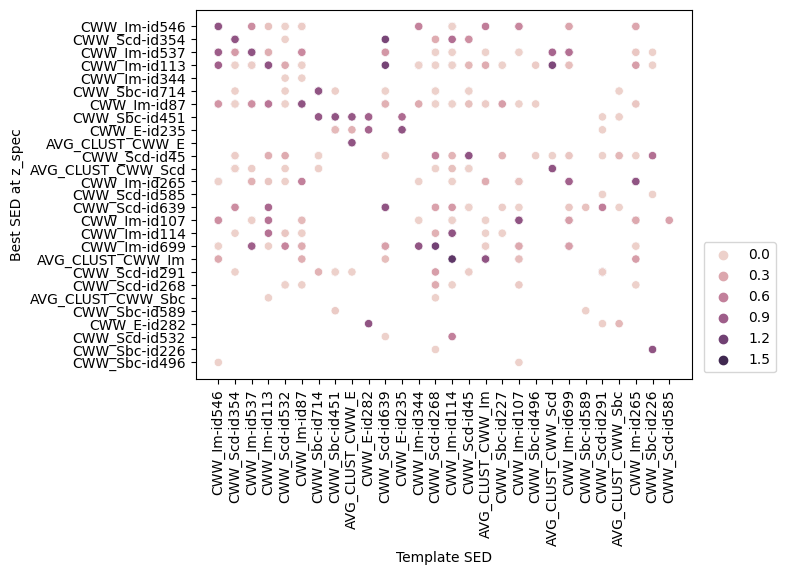

In [53]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='Template SED', y='Best SED at z_spec', hue='Odd ratio', ax=a)
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.))
a.tick_params(axis='x', labelrotation=90)

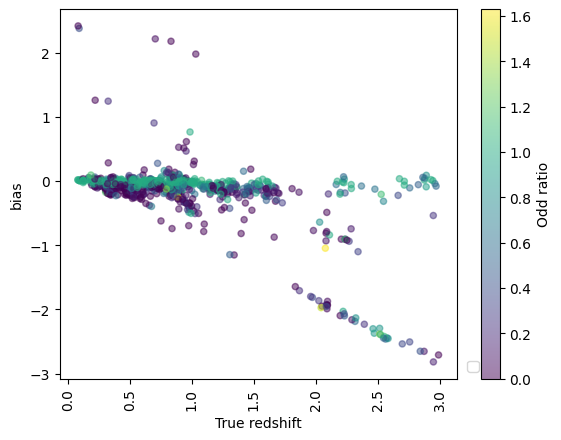

In [54]:
f,a = plt.subplots(1,1)
df_res.plot.scatter(x='True redshift', y='bias', c='Odd ratio', alpha=0.5, ax=a)
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.))
a.tick_params(axis='x', labelrotation=90)

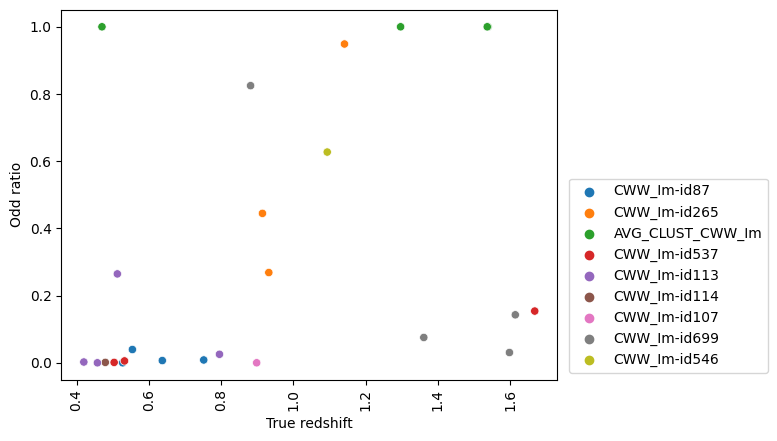

In [55]:
_sel = (df_res['Template SED'] == 'AVG_CLUST_CWW_Im') * ([not b for b in df_res['Outlier']])
sub_df = df_res[_sel]
f,a = plt.subplots(1,1)
sns.scatterplot(data=sub_df, x='True redshift', y='Odd ratio', hue='Best SED at z_spec', ax=a)
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.))
a.tick_params(axis='x', labelrotation=90)

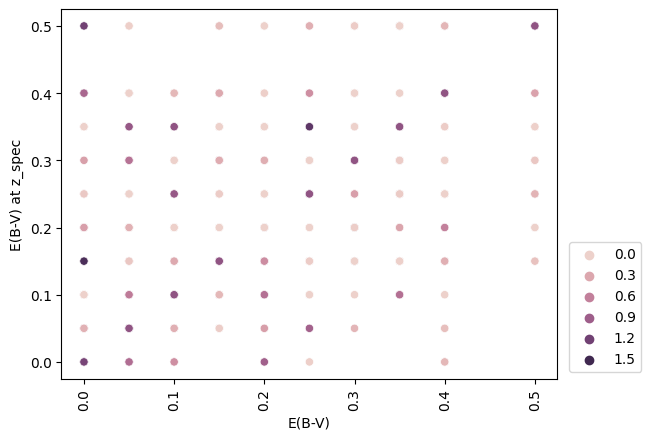

In [56]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='E(B-V)', y='E(B-V) at z_spec', hue='Odd ratio', ax=a)
a.legend(loc='lower left', bbox_to_anchor=(1.01, 0.))
a.tick_params(axis='x', labelrotation=90)

## Evidence-based Photo-Z

In [57]:
if True:
    seds_zs = []
    laws_zs = []
    ebvs_zs = []
    odds_zs = []
    z_means = []
    z_stds = []
    z_mods = []

    for kk in tqdm(keys) :
        chi2arr = results_dict[kk]
        probsarr, norm = probability_distrib(chi2arr)
        while abs(1-norm)>1.0e-5 :
            chi2arr = chi2arr + 2*jnp.log(norm)
            probsarr, norm = probability_distrib(chi2arr)

        evs_nosplit = evidence(probsarr, split_laws=False)
        id_t = np.nonzero([t.name == df_res.loc[kk, "Template SED"] for t in baseTemp_arr])[0][0]
        id_dust = np.nonzero([(d.name == df_res.loc[kk, "Extinction law"]) and (d.EBV == df_res.loc[kk, "E(B-V)"]) for d in dust_arr])[0][0]
        
        sorted_evs_flat = jnp.argsort(evs_nosplit, axis=None)
        sorted_evs = [ jnp.unravel_index(idx, evs_nosplit.shape) for idx in sorted_evs_flat ]
        sorted_evs.reverse()
        n_temp, n_dust = sorted_evs[0]
        
        pz_at_ev = probsarr[n_temp, n_dust, :] / np.trapz(probsarr[n_temp, n_dust, :], x=z_grid)
        #cum_distr = np.cumsum(pz_at_ev)
        z_mean = np.trapz(z_grid*pz_at_ev, x=z_grid)
        z_std = np.trapz(pz_at_ev*jnp.power(z_grid-z_mean, 2), x=z_grid)
        #_selmed = cum_distr > 0.5
        #z_med = z_grid[_selmed][0]
        try:
            z_mod = z_grid[np.nanargmax(pz_at_ev)]
        except ValueError:
            z_mod = np.nan
        seds_zs.append(baseTemp_arr[n_temp].name)
        laws_zs.append(dust_arr[n_dust].name)
        ebvs_zs.append(dust_arr[n_dust].EBV)
        odds_zs.append(float(evs_nosplit[n_temp, n_dust] / evs_nosplit[id_t, id_dust]))
        z_means.append(z_mean)
        z_stds.append(z_std)
        z_mods.append(z_mod)
        

    df_res["Highest evidence SED"] = seds_zs
    df_res["Highest evidence dust law"] = laws_zs
    df_res["Highest evidence E(B-V)"] = ebvs_zs
    df_res["Highest evidence odd ratio"] = odds_zs
    df_res["Highest evidence z_phot (mode)"] = z_mods
    df_res["Highest evidence z_phot (mean)"] = z_means
    df_res["Highest evidence sigma(z)"] = z_stds
    df_res.to_pickle(f"results_synthesis_{inputs['run name']}.pkl")

100%|██████████| 973/973 [08:34<00:00,  1.89it/s]


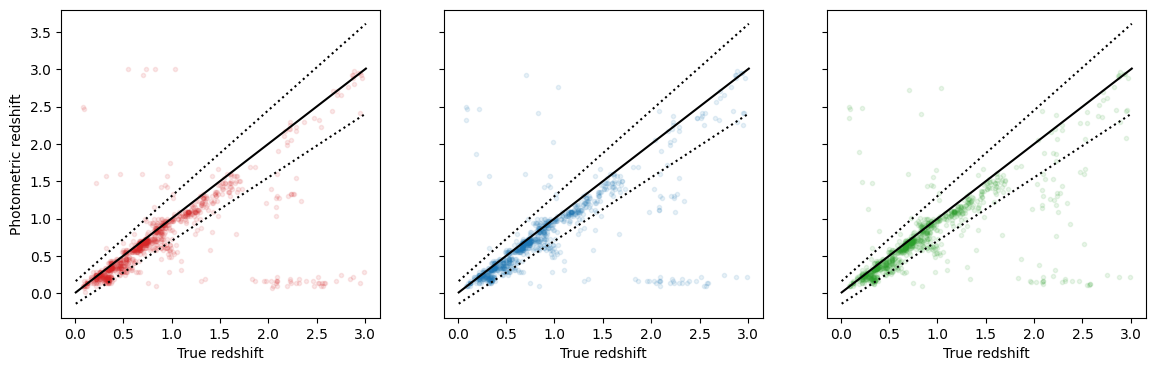

In [58]:
f,a = plt.subplots(1,3, sharey=True, figsize=(14, 4))
df_res.plot.scatter(x='True redshift', y='Photometric redshift', c='tab:red', s=9, alpha=0.1, ax=a[0])
df_res.plot.scatter(x='True redshift', y='Highest evidence z_phot (mode)', c='tab:blue', s=9, alpha=0.1, ax=a[1])
df_res.plot.scatter(x='True redshift', y='Highest evidence z_phot (mean)', c='tab:green', s=9, alpha=0.1, ax=a[2])
for _a in a:
    _a.plot(z_grid, z_grid, c='k')
    _a.plot(z_grid, z_grid+0.15*(1+z_grid), c='k', ls=':')
    _a.plot(z_grid, z_grid-0.15*(1+z_grid), c='k', ls=':')

## LEPHARE prior on N(z)
Based on [z-VVDS](https://cesam.lam.fr/vvds/)

### Construct the filters

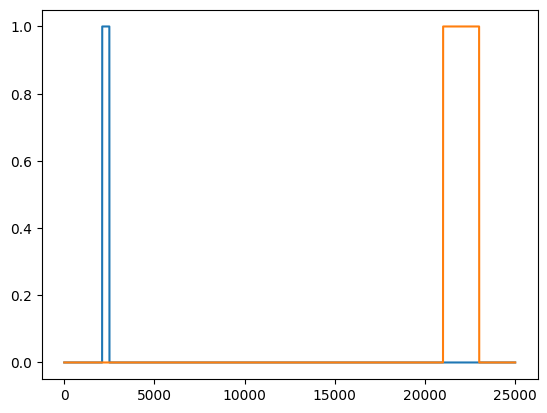

In [59]:
# NUV
nuv_transm = np.zeros_like(wl_grid)
nuv_transm[(wl_grid>=2100.)*(wl_grid<=2500.0)] = 1.0
NUV_filt = sedpyFilter("NUV", wl_grid, nuv_transm)

# NIR
nir_transm = np.zeros_like(wl_grid)
nir_transm[(wl_grid>=21000.)*(wl_grid<=23000.0)] = 1.0
NIR_filt = sedpyFilter("NIR", wl_grid, nir_transm)

plt.plot(wl_grid, nuv_transm)
plt.plot(wl_grid, nir_transm)

### Define the NUV-R rest-frame color corrected for dust-extinction

In [60]:
basetempl = [ bt for bt in baseTemp_arr if bt.name == df_res.loc[key_0,'Template SED'] ][0]
extlaw = [ dust for dust in dust_arr if (dust.name == df_res.loc[key_0, 'Extinction law'])\
                                          and (dust.EBV == df_res.loc[key_0, 'E(B-V)']) ][0]
                
obs = [ _obs for _obs in _obs_arr if _obs.num == key_0 ][0]
lnuv, lnir = jnp.array([Filter.ab_mag(filt.wavelengths, filt.transmission,\
                                        wl_grid, basetempl.flux*extlaw.transmission)\
                          for filt in (NUV_filt, NIR_filt)])
#nuv_nir_fluxes = jnp.power(10, -0.4*(nuv_nir_mags+48.6))
#lnuv, lnir = jnp.log10(nuv_nir_fluxes)
nuvk = lnuv-lnir #-2.5*(lnuv-lnir)
nuvk

DeviceArray(1.987504, dtype=float32)

### Define the prior in function of nuvk and Mag(i)
Pb : qui est 'red'? - c'est le redshift de la SED.

In [61]:
def nz_prior(z, nuvk, i_mag):
    val = 0.
    #if not ((i_mag<22. and z>2.) or (i_mag<20. and z>1.)):
    # Set up the parameters to define the redshift distribution
    if (nuvk>4.25):
        # Case E/S0
        # Color UV-K of PHOTO_230506/El_cww.sed.resample.new.resample15.inter 
        mod = 0
        zot = 0.45181
        kt = 0.13677
        alpt0 = 3.33078
        pcal = 0.89744
    elif (nuvk>3.19 and nuvk<4.25):
        # Case Sbc
        # Color UV-K of PHOTO_230506/Sbc_cww.sed.resample.new.resample8.inter 
        mod  = 1
        zot  = 0.16560
        kt   = 0.12983 
        alpt0= 1.42815
        pcal=  0.90868
    elif (nuvk>1.9 and nuvk<3.19):
        # Case Scd
        # Color UV-K of PHOTO_230506/Scd_cww.sed.resample.new.resample7.inter  -19.4878 + 21.1501
        mod  = 2
        zot  = 0.21072
        kt   = 0.14008
        alpt0= 1.58310
        pcal=  0.89747
    else:
        # Case Irr
        mod  = 3
        zot  = 0.20418
        kt   = 0.13773 
        alpt0= 1.34500
        pcal=  0.91760

    # P(z|T,m0)
    kk = max((i_mag-20), 0)
    zmax = zot + kt*kk
    pz = jnp.power(z,alpt0)*jnp.exp(-jnp.power((z/zmax),alpt0))

    # P(T|m0)
    ktf = jnp.array([0.47165, 0.30663, 0.12715, -0.34437])
    ft = jnp.array([0.43199, 0.07995, 0.31162, 0.21220])

    # Ratio for each type
    rappSum = jnp.sum(ft*jnp.exp(-ktf*kk))
    rapp = ft[mod]*jnp.exp(-ktf[mod]*kk)

    # Normalisation of the probability function
    pcal=jnp.power(zmax,alpt0+1)/alpt0*pcal

    # Final value
    val = pz / pcal * rapp/rappSum
    return val

In [62]:
P_prior = nz_prior(df_res.loc[key_0, 'Photometric redshift'], nuvk, df_res.loc[key_0, 'MagAB(hsc_iHSC)'])
P_prior

DeviceArray(0.36030787, dtype=float32)

In [63]:
from functools import partial

@partial(vmap, in_axes=(0,None,None))
def vect_nz_prior(z, nuvk, i_mag):
    return nz_prior(z, nuvk, i_mag)

In [64]:
grid_prior = vect_nz_prior(fine_z_grid, float(nuvk), df_res.loc[key_0, 'MagAB(hsc_iHSC)'])

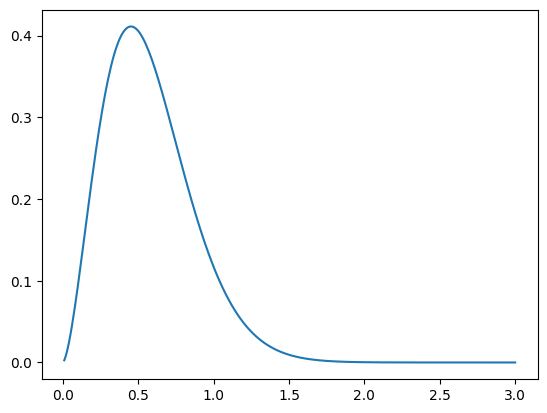

In [65]:
plt.plot(fine_z_grid, grid_prior)

Text(0, 0.5, '$P(z|T, m_{AB}(i))$')

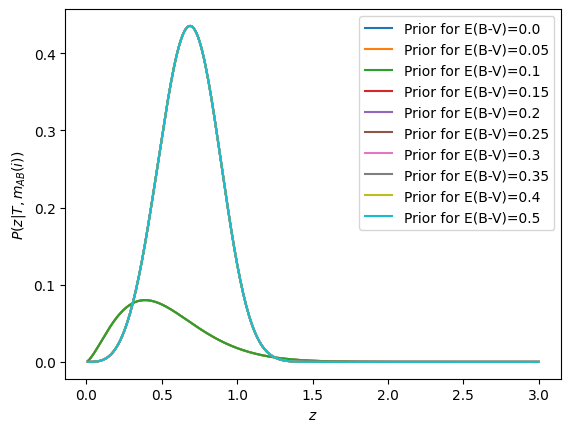

In [66]:
f,a = plt.subplots(1,1)
basetempl = baseTemp_arr[ [bt.name == df_res.loc[key_0,'Template SED'] for bt in baseTemp_arr][0] ]
extlaw = [ law for law in dust_arr if law.name==df_res.loc[key_0, 'Extinction law'] ]
obs = _obs_arr[ [_obs.num == key_0 for _obs in _obs_arr][0] ]
for law in extlaw:
    lnuv, lnir = jnp.array([Filter.ab_mag(filt.wavelengths, filt.transmission,\
                                            wl_grid, basetempl.flux*law.transmission)\
                              for filt in (NUV_filt, NIR_filt)])
    nuvk = lnuv-lnir
    grid_prior = vect_nz_prior(fine_z_grid, nuvk, df_res.loc[key_0, 'MagAB(hsc_iHSC)'])
    a.plot(fine_z_grid, grid_prior, label=f"Prior for E(B-V)={law.EBV}")
a.legend()
a.set_xlabel("$z$")
a.set_ylabel("$P(z|T, m_{AB}(i))$")

[DustLaw(name='Prevot', EBV=0.25, transmission=DeviceArray([0.        , 0.        , 0.        , ..., 0.95718527,
             0.9571897 , 0.9571941 ], dtype=float32))]


Text(0, 0.5, '$P(z|T, m_{AB}(i))$')

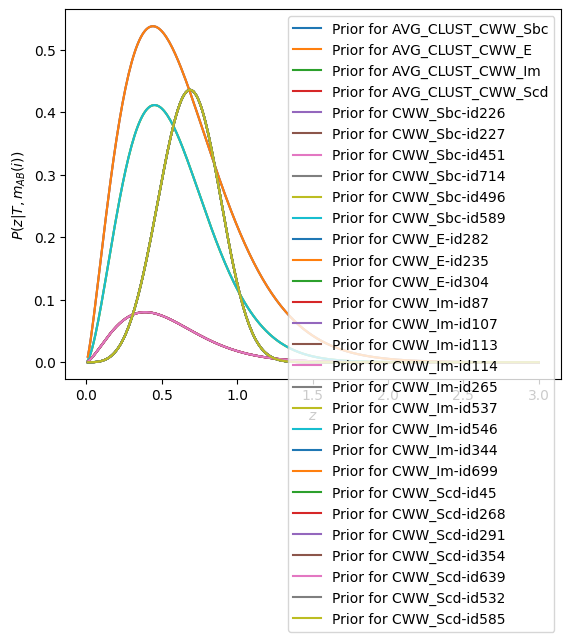

In [67]:
f,a = plt.subplots(1,1)
#basetempl = baseTemp_arr[ [bt.name == df_res.loc[key_0,'Template SED'] for bt in baseTemp_arr][0] ]
extlaw = [ law for law in dust_arr if law.name==df_res.loc[key_0, 'Extinction law'] ]
extlaw = [ law for law in extlaw if law.EBV==df_res.loc[key_0, 'E(B-V)'] ]
print(extlaw)
law=extlaw[0]
obs = _obs_arr[ [_obs.num == key_0 for _obs in _obs_arr][0] ]
for basetempl in baseTemp_arr:
    lnuv, lnir = jnp.array([Filter.ab_mag(filt.wavelengths, filt.transmission,\
                                            wl_grid, basetempl.flux*law.transmission)\
                              for filt in (NUV_filt, NIR_filt)])
    nuvk = lnuv-lnir
    grid_prior = vect_nz_prior(fine_z_grid, nuvk, df_res.loc[key_0, 'MagAB(hsc_iHSC)'])
    a.plot(fine_z_grid, grid_prior, label=f"Prior for {basetempl.name}")
a.legend()
a.set_xlabel("$z$")
a.set_ylabel("$P(z|T, m_{AB}(i))$")

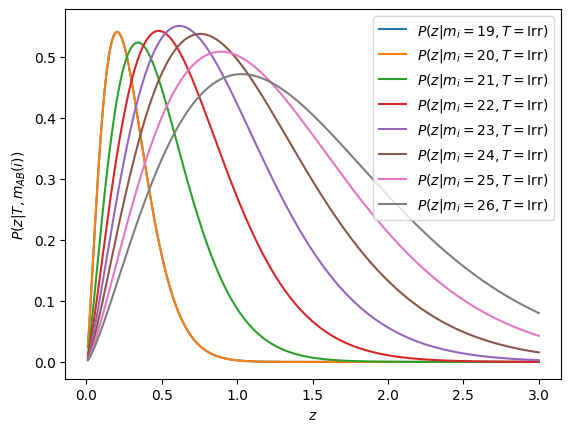

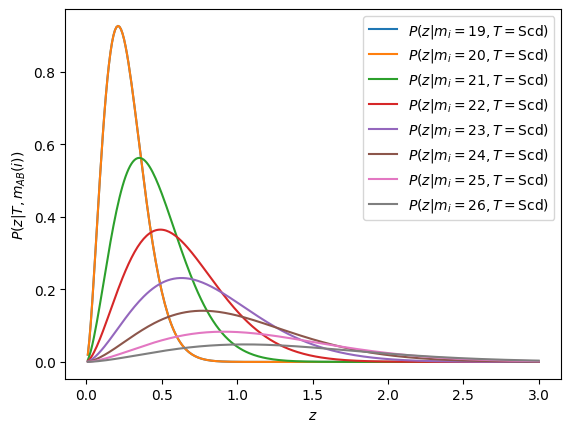

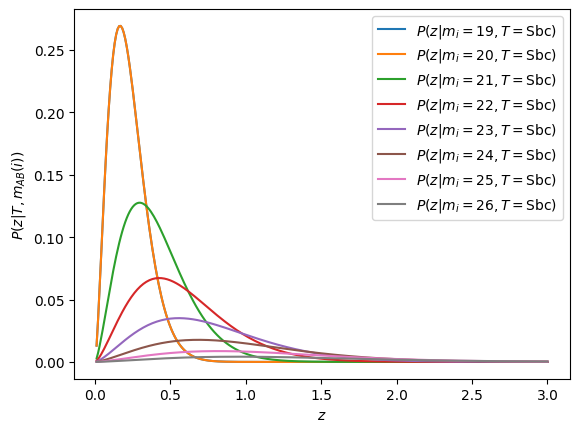

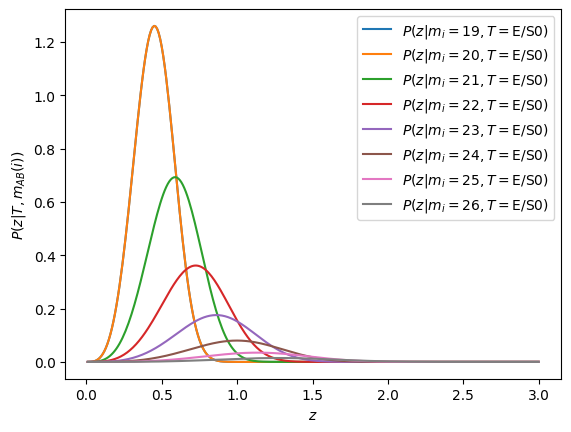

In [68]:
typNUV_dict = { 'Irr':1.5, 'Scd':2.5, 'Sbc':3.5, 'E/S0':4.5 }
for typ in typNUV_dict:
    f,a = plt.subplots(1,1)
    for magi in range(19, 27, 1):
        grid_prior = vect_nz_prior(fine_z_grid, typNUV_dict[typ], magi)
        a.plot(fine_z_grid, grid_prior, label=f"$P(z|m_i=${magi}$, T=${typ}$)$")
    a.legend()
    a.set_xlabel("$z$")
    a.set_ylabel("$P(z|T, m_{AB}(i))$")

In [69]:
PriorParams = namedtuple('PriorParams', ['mod', 'zot', 'kt', 'alpt0', 'pcal', 'nuv_range'])

prior_params_set = (PriorParams(0, 0.45181, 0.13677, 3.33078, 0.89744, (4.25, jnp.inf)),\
                    PriorParams(1, 0.16560, 0.12983, 1.42815, 0.90868, (3.19, 4.25)),\
                    PriorParams(2, 0.21072, 0.14008, 1.58310, 0.89747, (1.9, 3.19)),\
                    PriorParams(3, 0.20418, 0.13773, 1.34500, 0.91760, (-jnp.inf, 1.9)),\
                   )

prior_pars_E_S0, prior_pars_Sbc, prior_pars_Scd, prior_pars_Irr = prior_params_set

@jit
@vmap
def prior_zot(nuvk):
    val = prior_pars_Irr.zot +\
            (prior_pars_Scd.zot - prior_pars_Irr.zot)*jnp.heaviside(nuvk-prior_pars_Scd.nuv_range[0], 0)+\
            (prior_pars_Sbc.zot - prior_pars_Scd.zot)*jnp.heaviside(nuvk-prior_pars_Sbc.nuv_range[0], 0)+\
            (prior_pars_E_S0.zot - prior_pars_Sbc.zot)*jnp.heaviside(nuvk-prior_pars_E_S0.nuv_range[0], 0)
    return val

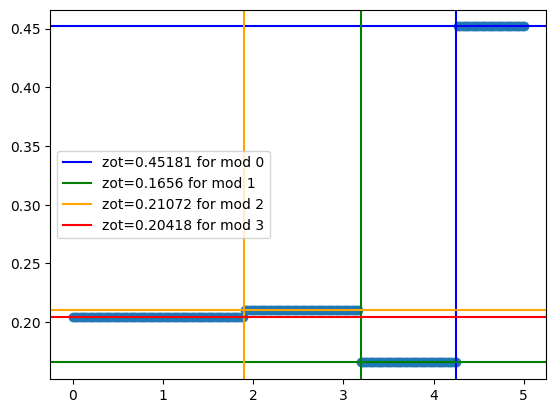

In [70]:
f,a = plt.subplots(1,1)
nuvrange = jnp.linspace(0., 5., 200)
a.scatter(nuvrange, prior_zot(nuvrange))
for pparams, cl in zip(prior_params_set, ['blue', 'green', 'orange', 'red']):
    if pparams.mod<3:
        a.axvline(pparams.nuv_range[0], c=cl)
    a.axhline(pparams.zot, c=cl, label=f"zot={pparams.zot} for mod {pparams.mod}")
a.legend()

In [71]:
val = 3.
jnp.logical_not(jnp.isfinite(val)).astype(float)*0.+jnp.isfinite(val).astype(float)*val

DeviceArray(3., dtype=float32)

/pbs/home/j/jocheval/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/pbs/home/j/jocheval/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/pbs/home/j/jocheval/.local/lib/python3.8/site-pac

Text(0.5, 0, 'Redshift z')

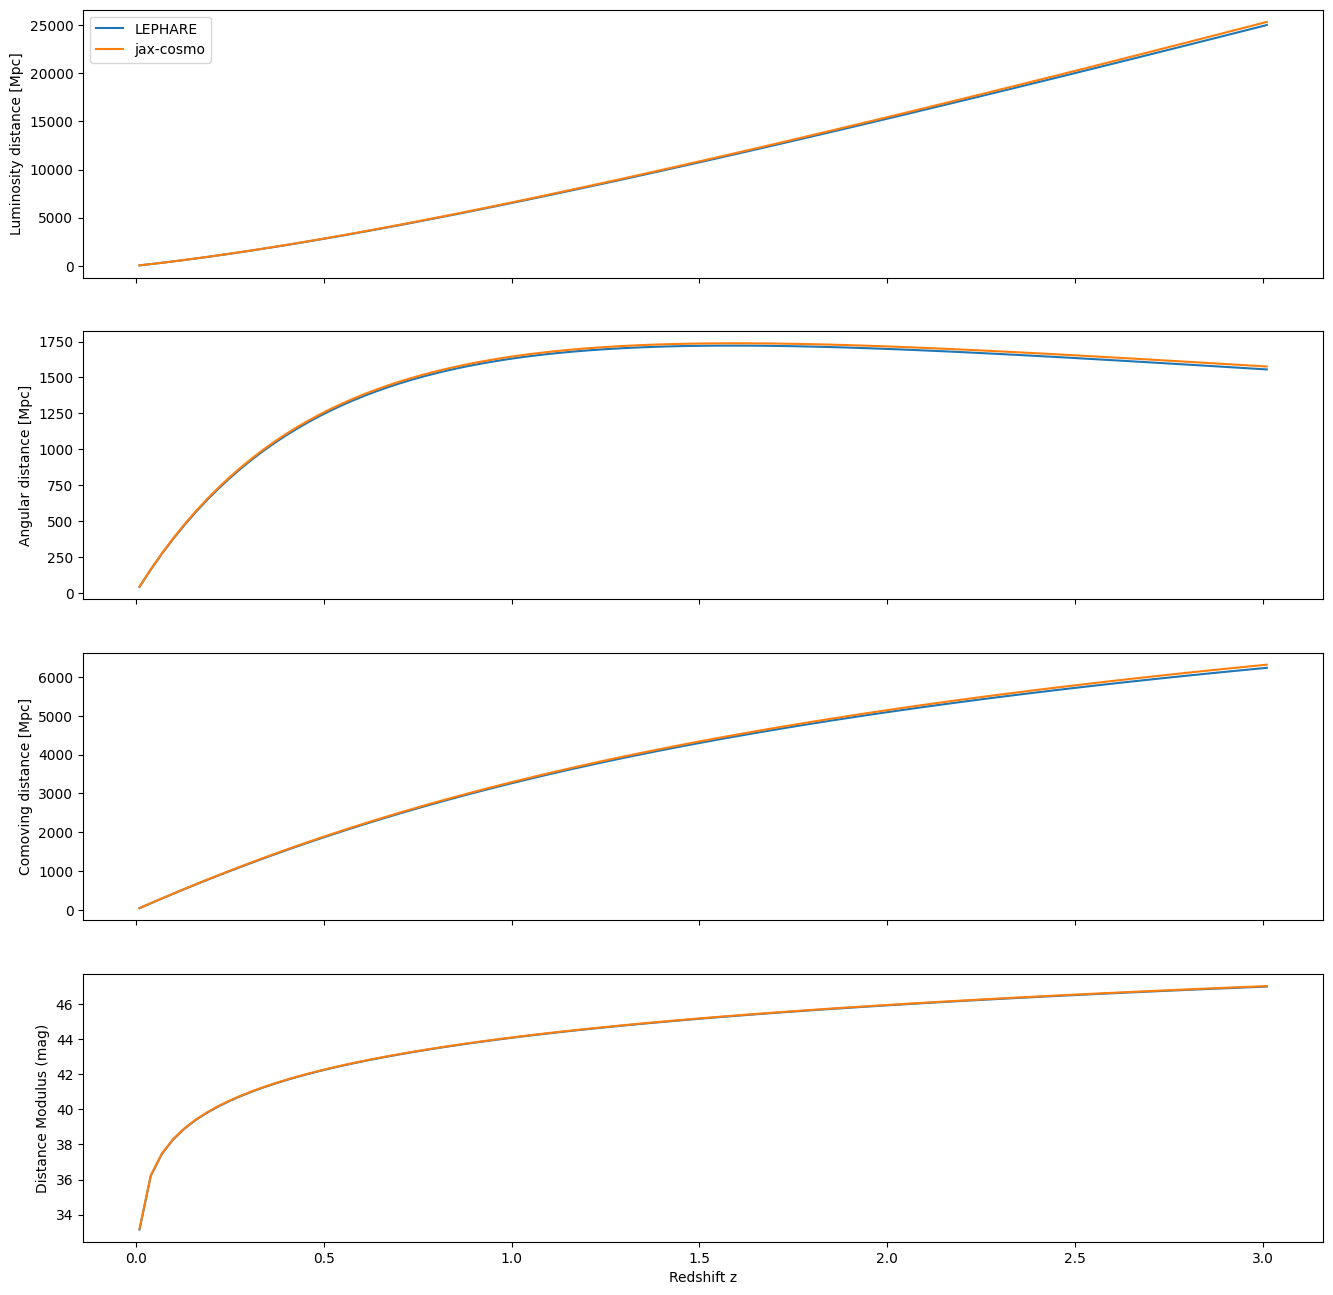

In [72]:
j_cosmo = Cosmology.make_jcosmo(inputs['Cosmology']['h0'])
a_grid = jc.utils.z2a(z_grid)

@vmap
def v_distLum(z):
    return Cosmology.distLum(cosmo, z)

@vmap
def v_distAng(z):
    return Cosmology.distAng(cosmo, z)

@vmap
def v_distMet(z):
    return Cosmology.distMet(cosmo, z)

@vmap
def v_distMod(z):
    return Cosmology.distMod(cosmo, z)


f,a = plt.subplots(4,1, figsize=(16, 16), sharex=True)
a = a.ravel()
a[0].plot(z_grid, v_distLum(z_grid), label="LEPHARE")
a[0].plot(z_grid, Cosmology.calc_distLum(j_cosmo, z_grid), label="jax-cosmo") # (1.+z_grid)*jc.background.radial_comoving_distance(j_cosmo, a_grid)/j_cosmo.h
a[0].set_ylabel('Luminosity distance [Mpc]')
a[0].legend()
a[1].plot(z_grid, v_distAng(z_grid), label="LEPHARE")
a[1].plot(z_grid, Cosmology.calc_distAng(j_cosmo, z_grid), label="jax-cosmo") # jc.background.angular_diameter_distance(j_cosmo, a_grid)/j_cosmo.h
a[1].set_ylabel('Angular distance [Mpc]')
a[2].plot(z_grid, v_distMet(z_grid), label="LEPHARE")
a[2].plot(z_grid, Cosmology.calc_distM(j_cosmo, z_grid), label="jax-cosmo")
a[2].set_ylabel('Comoving distance [Mpc]')
a[3].plot(z_grid, v_distMod(z_grid), label="LEPHARE")
a[3].plot(z_grid, Cosmology.calc_distMod(j_cosmo, z_grid), label="jax-cosmo")
a[3].set_ylabel('Distance Modulus (mag)')
a[3].set_xlabel('Redshift z')